## Projet 4 : Construisez un modèle de scoring

## Contexte

Une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin qule e modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un clienée

Notre objectif développer cet algorithme de classificationns.

## Librairies utilisées avec le langage Python:

In [ ]:
# Importation des librairies
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC # svC car problème de classification (sinon SVR pour la regression)
from sklearn.model_selection import  GridSearchCV, cross_validate, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn import  metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,fbeta_score,roc_auc_score,confusion_matrix,precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, make_scorer
import tensorflow as tf; tf.keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import time
import os

import warnings
warnings.filterwarnings('ignore')

shap.initjs()

## Données brutes:

Nous avons 4 fichiers CSV :
- X_train : dataframe d'entrainement
- X_test : dataframe de test
- y_train : array de la variable cible pour le dataframe d'entrainement
- y_test : array de la variable cible pour le dataframe de test


In [ ]:
# Chargement des données brutes du fichier CSV
X_train = pd.read_csv('/tutorial-env/OCR/Projet 4/X_train.csv')
X_test = pd.read_csv('/tutorial-env/OCR/Projet 4/X_test.csv')
y_train = pd.read_csv('/tutorial-env/OCR/Projet 4/y_train.csv')
y_test = pd.read_csv('/tutorial-env/OCR/Projet 4/y_test.csv')


## Normalisation et équilibrage des données:

Afin que les différents ordres de grandeur des variables n'impactent pas les résultats des modèles, normalisons les données pour que chaque variable ait une moyenne égale à 0 et une variance égale à 1.

In [ ]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données (entrainement de l'imputer seulement sur les données d'entrainement pour éviter la fuite de données)
X_train_norm = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
    )
X_test_norm = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
    )

# Save the processed data
X_train_norm.to_csv('D:/tutorial-env/OCR/Projet 4/X_train_norm.csv', index=False)
X_test_norm.to_csv('D:/tutorial-env/OCR/Projet 4/X_test_norm.csv', index=False)

X_train_norm.describe(include="all")

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,...,EXT_SOURCE_2 EXT_SOURCE_3 AGE,EXT_SOURCE_2 AGE^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 AGE,EXT_SOURCE_3 AGE^2,AGE^3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
count,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,...,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05
mean,-1.740195e-17,-2.566247e-17,-1.001587e-16,6.598301e-17,3.396630e-17,-1.191998e-16,1.198930e-16,1.344139e-16,-1.502561e-16,-7.081187e-17,...,2.041155e-16,-3.093938e-16,-1.830166e-16,4.607908e-17,-5.362040e-16,-2.288249e-16,-2.544585e-17,2.618236e-17,4.396846e-16,8.224409e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.247234e-01,-7.181585e-01,-1.504877e+00,-5.788480e-01,-5.533760e-01,-1.374886e+00,-1.755635e+00,-1.334438e+00,-1.488335e+00,-7.174946e+00,...,-1.583469e+00,-1.498425e+00,-1.285525e+00,-1.474042e+00,-1.490044e+00,-1.236052e+00,-1.469247e+00,-1.910678e+00,-1.407703e+00,-1.229568e+00
25%,-3.247234e-01,-7.181585e-01,-1.504877e+00,-5.788480e-01,-2.177083e-01,-8.160175e-01,-7.296359e-01,-8.105069e-01,-7.856671e-01,-2.393255e-01,...,-7.856490e-01,-7.913814e-01,-7.778655e-01,-7.364646e-01,-7.992879e-01,-8.379680e-01,-7.211528e-01,-7.006335e-01,-7.465883e-01,-6.704507e-01
50%,-3.247234e-01,-7.181585e-01,6.645063e-01,-5.788480e-01,-8.726755e-02,-2.124392e-01,-1.513679e-01,-2.378382e-01,-1.460626e-01,2.833847e-01,...,-1.347512e-01,-2.144636e-01,-1.989178e-01,-1.525855e-01,-2.310782e-01,-3.044047e-01,-2.591908e-01,-1.918845e-01,-1.652879e-01,-2.576931e-01
75%,-3.247234e-01,1.392450e+00,6.645063e-01,8.093218e-01,1.301338e-01,5.219143e-01,5.168184e-01,3.835683e-01,5.636207e-01,6.184433e-01,...,6.481073e-01,6.342508e-01,5.403890e-01,5.418466e-01,6.217268e-01,6.868723e-01,4.461135e-01,5.076919e-01,4.598731e-01,3.388940e-01
max,3.079544e+00,1.392450e+00,6.645063e-01,2.579638e+01,4.515422e+02,8.572978e+00,1.399186e+01,9.509714e+00,3.734523e+00,1.053177e+00,...,4.465937e+00,3.695439e+00,3.811027e+00,4.266265e+00,3.987615e+00,2.938628e+00,3.005412e+01,1.793057e+01,3.145881e+00,4.697029e+00


Pour éliminer un biais dans l'apprentissage de nos modèles, ocupons-nous maintenant du rééquilibrage des données avec la méthode SMOTE (Synthetic Minority Oversampling Technique) qui va créer de nouveaux exemples de la classe minoritaires plausibles d'après les exemples actuels de la classe minoritaire.

In [ ]:
y_train.shape

(246008, 1)

In [ ]:
# Méthode SMOTE pour l'équilibrage des données
oversample = SMOTE()
X_train_eq, y_train_eq = oversample.fit_resample(X_train_norm, y_train)

Comparons la différence de distribution de notre variable cible avant et après la méthode SMOTE :

<Axes: title={'center': 'Distribution de la variable cible "TARGET" initial'}, xlabel='TARGET_x', ylabel='count'>

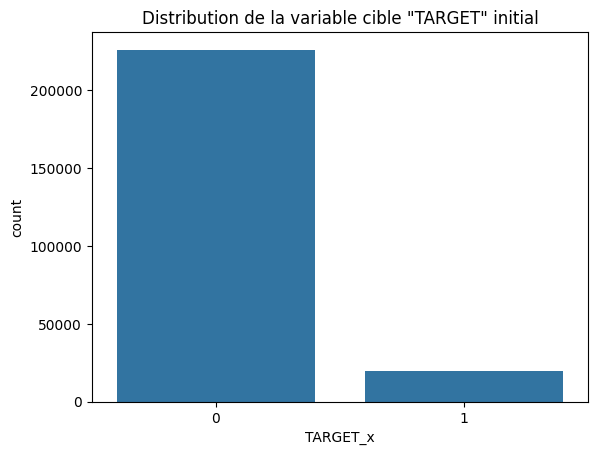

In [ ]:
plt.title(f'Distribution de la variable cible "TARGET" initial')
sns.countplot(y_train, x="TARGET_x")

<Axes: title={'center': 'Distribution de la variable cible "TARGET"après SMOTE'}, xlabel='TARGET_x', ylabel='count'>

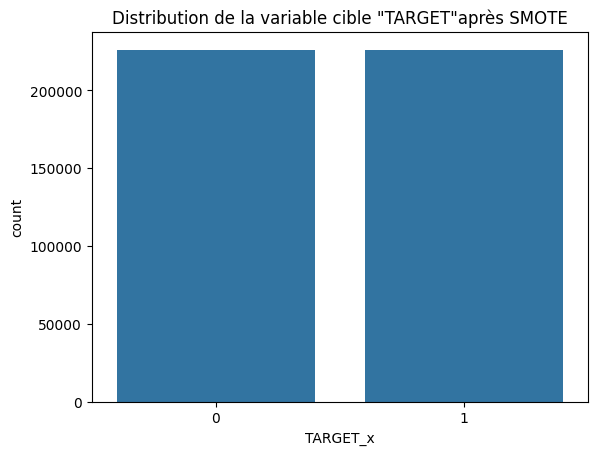

In [ ]:
plt.title(f'Distribution de la variable cible "TARGET"après SMOTE')
sns.countplot(y_train_eq, x="TARGET_x")

In [ ]:
y_train_eq.shape

(452248, 1)

Nos données d'entrainements sont bien équilibrées, cependant, le nombre de lignes de notre dataframe est significativment plus important et va induire des temps d'apprentissage et d'éxécution trop longs.

Testons donc une méthode qui qui supprimera des éléments de la classe majoritaire à la place avec la fonction RandomUnderSampler:


In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_eq, y_train_eq = rus.fit_resample(X_train_norm, y_train)

<Axes: title={'center': 'Distribution de la variable cible "TARGET" après RandomUnderSampler'}, xlabel='TARGET_x', ylabel='count'>

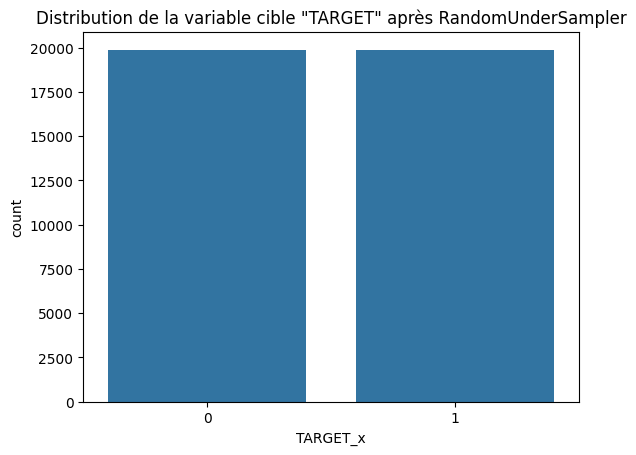

In [ ]:
plt.title(f'Distribution de la variable cible "TARGET" après RandomUnderSampler')
sns.countplot(y_train_eq, x="TARGET_x")

In [ ]:
y_train_eq.shape

(39768, 1)


 Nos données d'entrainements sont bien équilibrées et le nombre de lignes est beaucoup plus petite ce qui va nous permettre de pouvoir faire tourner nos algorithmes plus rapidement.

 Bien entendu, nous laissons les données de tests déséquilibrées puisqu'elles doivent refléter la réalité.

## Modélisation et évaluation:

Nous allons tester différents modèles de classification binaire et évaluer leur efficacité en terme de performances et de temps d'entainement et d'exécution.

Pour l'évaluation des performances nous allons calculer différentes métriques :
- l'accuracy (efficacité d'un modèle à prédire correctement à la fois les individus positifs et négatifs)
- la précision (nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit)
- le recall (nombre de positifs bien prédit (VP) divisé par l’ensemble des positifs)
- le F1 score (moyenne harmonique du recall et de la precision)
- le F beta score (avec beta>1, pour accorder plus d’importance au recall (autrement dit aux Faux Négatif) puisque la prédiction des difficultés de remboursement est plus importante pour l'entreprise. En effet, les FN coûtent plus d'argent que les Faux Positifs.)

### Modèle de base :

Notre modèle de base va effectuer des prédictions basées sur la valeur de la variable la plus fréquente.

In [ ]:
#Entrainement du classifieur
clf = DummyClassifier(strategy=  "most_frequent",random_state=42).fit(X_train_eq,y_train_eq)

#Prédiction de la variable cible sur la base de données test
y_pred = clf.predict(X_test_norm)
y_pred_proba = clf.predict_proba(X_test_norm)[:, 1]

#Distribution de la variable cible sur la base de données test
print('y réel : \n' +  str(y_test.value_counts())+'\n')

#Distribution de la variable cible prédite
print('y prédit: \n' + str(pd.Series(y_pred).value_counts()))

y réel : 
TARGET_x
0           56562
1            4941
Name: count, dtype: int64

y prédit: 
0    61503
Name: count, dtype: int64


In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred))) #si problème de régression, remplacé par R²
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('F beta Score (avec beta=2) : ' + str(fbeta_score(y_test,y_pred, beta=2)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred)))

Accuracy Score : 0.919662455489976
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
F beta Score (avec beta=2) : 0.0
Aire sous la courbe ROC : 0.5


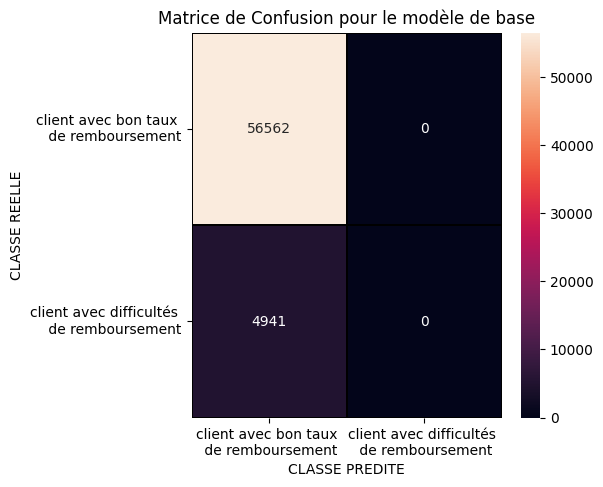

In [ ]:
# Graphique de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le modèle de base')
plt.show()

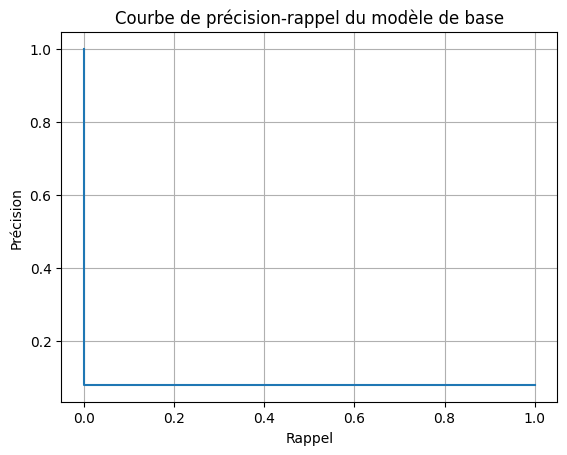

In [ ]:
# Graphique précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du modèle de base')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du modèle de base')

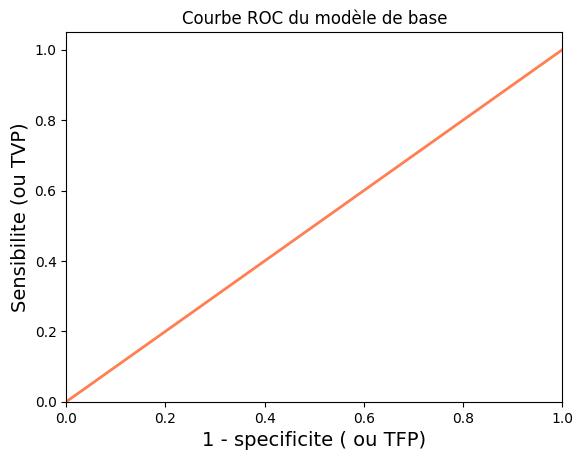

In [ ]:
# Graphique courbe ROC
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du modèle de base')

Nous voyons que prédire la classe la plus représentée (ici 0) permet d'obtenir une bonne accuracy mais des résultats médiocres pour tous les autres scores.

De plus, il n'y a aucune minimisation des FN puisque toutes les prédictions sont égales à 0 donc avec un bon taux de remboursement. Or c'est ce que l'on souhaite obtenir !

### Modèles linéaires de régression logistique :

Le modèle de régression logistique est un modèle simple qui analyse les relations entre une variable cible binaire et l’ensemble des autres variables indépendantes. Cette relation est exprimée comme une équation qui prédit la probabilité de réalisation des deux classes de la variable cible comme une combinaison linéaire de paramètres suivant une fonction logistique.


In [ ]:
# Création d'une instance de modèle de régression logistique
lr = LogisticRegression(solver="saga",max_iter=1000,n_jobs=-1,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train_eq,y_train_eq)
y_pred_lr = lr.predict(X_test_norm)
y_pred_lr_prob = lr.predict_proba(X_test_norm)[:, 1]


In [ ]:
# score de la régression logistique
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_lr, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_lr)))

Accuracy Score : 0.6857063883062615
Precision Score : 0.15787721717628037
Recall Score : 0.6719287593604534
F1 Score : 0.25567963034270313
F beta Score (avec beta=3) : 0.5068857064337842
Aire sous la courbe ROC : 0.6794193494479153


In [ ]:
lr = LogisticRegression(solver="saga", penalty='elasticnet',max_iter=200, n_jobs=-1,random_state=42)
params = {'C': np.logspace(-5, 5, 10),"l1_ratio": np.linspace(0, 1, 10)}

# optimisation des paramètres avec la grid search
grid_lr = GridSearchCV(lr, params,cv=3, n_jobs=-1)
grid_lr.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_lr_gs = grid_lr.best_estimator_

In [ ]:
print(best_model_lr_gs)

LogisticRegression(C=0.021544346900318846, l1_ratio=1.0, max_iter=200,
                   n_jobs=-1, penalty='elasticnet', random_state=42,
                   solver='saga')


In [ ]:
cvres_lr=pd.DataFrame(grid_lr.cv_results_)
cvres_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,34.232880,6.599786,0.113377,0.014286,0.00001,0.0,"{'C': 1e-05, 'l1_ratio': 0.0}",0.670112,0.676147,0.662643,0.669634,0.005523,80
1,5.466768,0.528485,0.266100,0.138358,0.00001,0.111111,"{'C': 1e-05, 'l1_ratio': 0.1111111111111111}",0.500000,0.500000,0.500000,0.500000,0.000000,88
2,4.339606,1.176609,0.221416,0.046903,0.00001,0.222222,"{'C': 1e-05, 'l1_ratio': 0.2222222222222222}",0.500000,0.500000,0.500000,0.500000,0.000000,88
3,1.913685,0.141065,0.183490,0.035124,0.00001,0.333333,"{'C': 1e-05, 'l1_ratio': 0.3333333333333333}",0.500000,0.500000,0.500000,0.500000,0.000000,88
4,2.635015,0.218666,0.247609,0.052093,0.00001,0.444444,"{'C': 1e-05, 'l1_ratio': 0.4444444444444444}",0.500000,0.500000,0.500000,0.500000,0.000000,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,199.607409,2.901782,0.174399,0.045740,100000.0,0.555556,"{'C': 100000.0, 'l1_ratio': 0.5555555555555556}",0.679617,0.684294,0.675543,0.679818,0.003575,30
96,196.692679,0.841885,0.123978,0.007849,100000.0,0.666667,"{'C': 100000.0, 'l1_ratio': 0.6666666666666666}",0.679617,0.684294,0.675543,0.679818,0.003575,30
97,193.298370,5.008456,0.112614,0.005688,100000.0,0.777778,"{'C': 100000.0, 'l1_ratio': 0.7777777777777777}",0.679617,0.684294,0.675543,0.679818,0.003575,30
98,174.315449,8.164331,0.078950,0.004650,100000.0,0.888889,"{'C': 100000.0, 'l1_ratio': 0.8888888888888888}",0.679617,0.684294,0.675543,0.679818,0.003575,30


In [ ]:
cols= [i for i in cvres_lr.columns if "split" not in i ]
cvres_lr=cvres_lr [cols].sort_values("rank_test_score")
cvres_lr.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,mean_test_score,std_test_score,rank_test_score
39,196.988990,3.689643,0.192459,0.029659,0.021544,1.0,"{'C': 0.021544346900318846, 'l1_ratio': 1.0}",0.681704,0.003535,1
38,198.400965,22.369327,0.202270,0.005218,0.021544,0.888889,"{'C': 0.021544346900318846, 'l1_ratio': 0.8888...",0.681603,0.003424,2
21,210.362183,4.055863,0.199631,0.034853,0.001668,0.111111,"{'C': 0.0016681005372000592, 'l1_ratio': 0.111...",0.681578,0.003537,3
36,209.249161,34.921916,0.164326,0.031606,0.021544,0.666667,"{'C': 0.021544346900318846, 'l1_ratio': 0.6666...",0.681201,0.003906,4
37,230.538664,32.971554,0.182943,0.017296,0.021544,0.777778,"{'C': 0.021544346900318846, 'l1_ratio': 0.7777...",0.681151,0.003602,5
35,237.431261,11.286176,0.205218,0.037657,0.021544,0.555556,"{'C': 0.021544346900318846, 'l1_ratio': 0.5555...",0.680849,0.003690,6
34,223.286825,12.438805,0.145592,0.013508,0.021544,0.444444,"{'C': 0.021544346900318846, 'l1_ratio': 0.4444...",0.680597,0.003878,7
49,231.733528,37.886579,0.318108,0.063581,0.278256,1.0,"{'C': 0.2782559402207126, 'l1_ratio': 1.0}",0.680346,0.003678,8
48,290.838939,18.018269,0.271605,0.071338,0.278256,0.888889,"{'C': 0.2782559402207126, 'l1_ratio': 0.888888...",0.680271,0.003800,9
33,190.550026,6.430860,0.204971,0.016035,0.021544,0.333333,"{'C': 0.021544346900318846, 'l1_ratio': 0.3333...",0.680220,0.004133,10


Les hyperparamètres optimisés correspondent au couple {'C': 0.021544, 'l1_ratio': 1.0} et entrainent une maximisation  du mean_test_score égal à 0.681704.


Passons à la prédiction avec ce modèle optimisée :

In [ ]:
# prédiction sur les meilleurs hyperparamètres
y_prob_lr_gd = best_model_lr_gs.predict_proba(X_test_norm)[:, 1]
y_pred_lr_gd = best_model_lr_gs.predict(X_test_norm)

In [ ]:
# score de la régression logistique avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_lr_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_lr_gd)))

Accuracy Score : 0.6767637351023528
Precision Score : 0.1548449701954623
Recall Score : 0.6782027929568913
F1 Score : 0.2521254984576029
F beta Score (avec beta=3) : 0.5068824686129179
Aire sous la courbe ROC : 0.7428319278336175


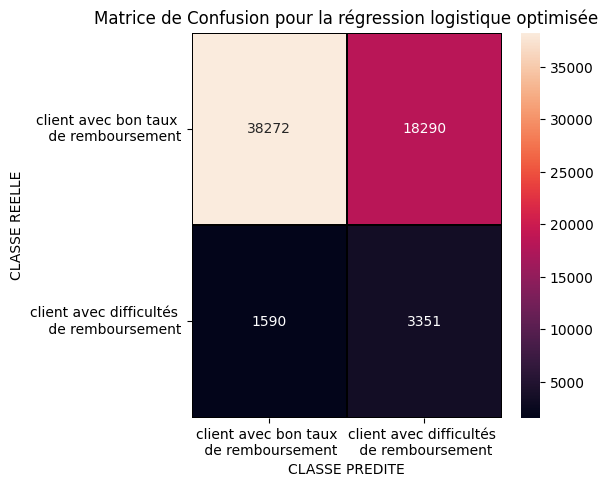

In [ ]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique optimisée')
plt.show()

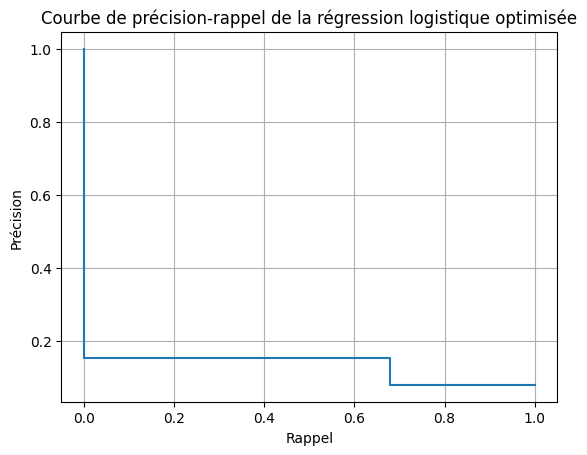

In [ ]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr_gd)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

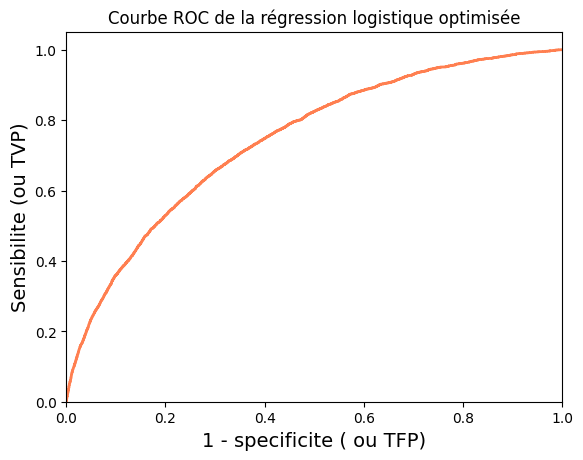

In [ ]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_prob_lr_gd)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

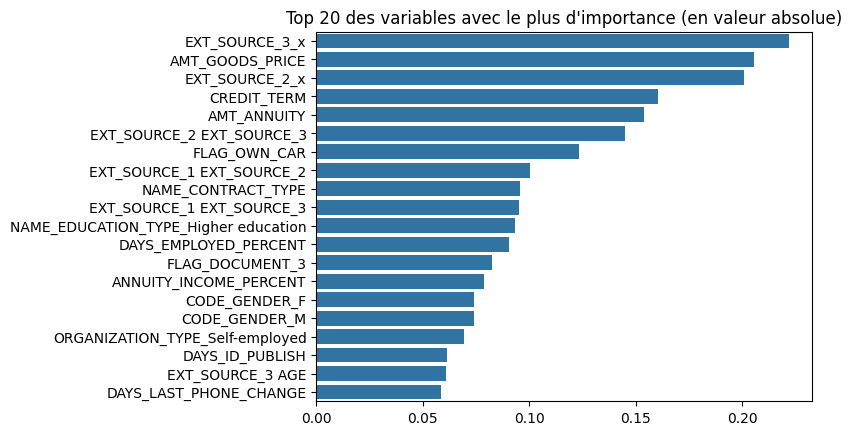

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_lr = (pd.Series(best_model_lr_gs.coef_[0],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_lr, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que les données du feature engineering ont une importance élevée dans ce modèle optimisé de régression logistique.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [ ]:
# F3 score selon les différents seuils de décision
f3_score_lr=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_lr_gd > i, 1, 0))
  f3_score_lr.append(str(fbeta_score(y_test,preds, beta=3)))


In [ ]:
y_prob_lr_gd

array([0.17043602, 0.69096539, 0.14590424, ..., 0.4196634 , 0.22384941,
       0.58674231])

In [ ]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_lr})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


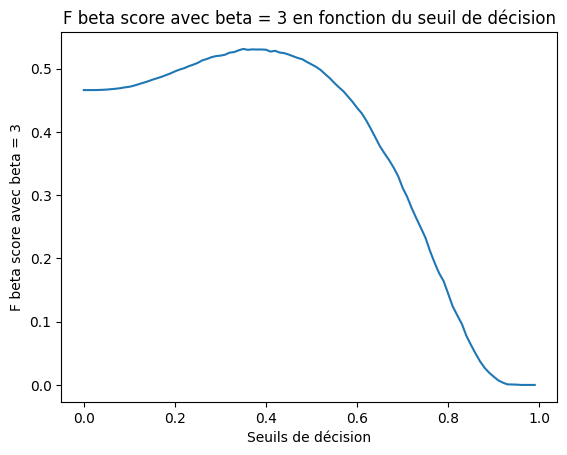

In [ ]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [ ]:
# Cherchons la valeur maximale du F3 score
f3_score_lr_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_lr=df.loc[df['f3_score']==f3_score_lr_max,['abs']]
seuil_opt_lr=seuil_opt_lr.values[0,0]
seuil_opt_lr

0.35

In [ ]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_lr_opt=(y_prob_lr_gd> seuil_opt_lr).astype(int)

In [ ]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_lr_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_lr_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_lr_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_lr_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_lr_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_lr_opt)))

Accuracy Score : 0.4609693836073037
Precision Score : 0.11724961332862996
Recall Score : 0.8745193280712407
F1 Score : 0.20677609226204718
F beta Score (avec beta=3) : 0.5313445316150611
Aire sous la courbe ROC : 0.6496814312998613


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,35.

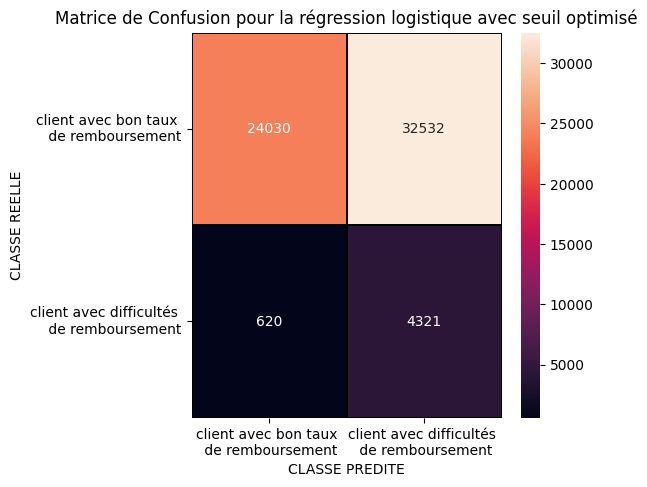

In [ ]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_lr_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

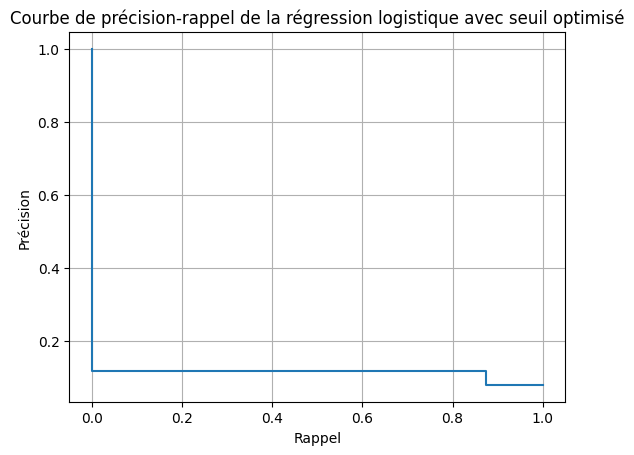

In [ ]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_lr_opt)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique avec seuil optimisé')

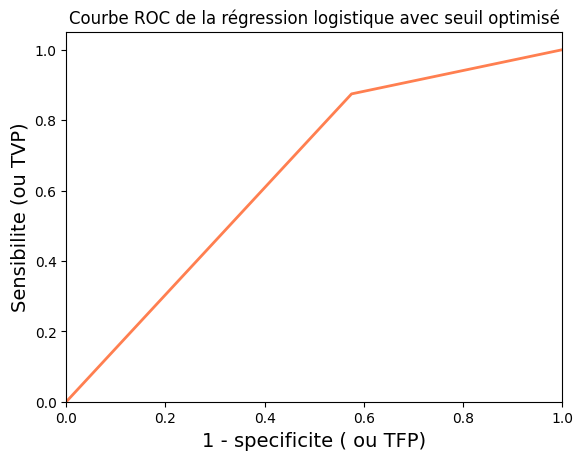

In [ ]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_lr_opt)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique avec seuil optimisé')

### Modèles linéaires de Machines à Vecteurs de Support (SVM):

Ils ont pour but de séparer linéairement les données en classes à l’aide d’une frontière aussi « simple » que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale. Cette distance est aussi appelée « marge » et les SVMs sont ainsi qualifiés de « séparateurs à vaste marge », les « vecteurs de support » étant les données les plus proches de la frontière.

La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons, et inversement pour la version duale.

In [ ]:
# Création d'une instance de modèle de SVM de classification
svm = LinearSVC( tol=1e-5,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
svm.fit(X_train_eq,y_train_eq)
y_pred_svm = svm.predict(X_test_norm)



In [ ]:
# score de la SVM
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm)))

Accuracy Score : 0.6872022502967335
Precision Score : 0.15580913862005874
Recall Score : 0.6549281521959117
F1 Score : 0.2517308440295605
F beta Score (avec beta=3) : 0.49602992121156375
Aire sous la courbe ROC : 0.6724748607236763


In [ ]:
svm = LinearSVC( tol=1e-5,max_iter=200,random_state=42)
params={"C": np.logspace(-5, 5, 10),"penalty":['l1','l2']}

# optimisation des paramètres avec la grid search
grid_svm = GridSearchCV(svm, params,cv=3, n_jobs=-1)
grid_svm.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_gs = grid_svm.best_estimator_

In [ ]:
print(best_model_svm_gs)

LinearSVC(C=0.021544346900318846, max_iter=200, random_state=42, tol=1e-05)


In [ ]:
cvres_svm=pd.DataFrame(grid_svm.cv_results_)
cvres_svm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.282826,0.035478,0.000000,0.000000,0.00001,l1,"{'C': 1e-05, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,11
1,1.246378,0.069803,0.060707,0.012188,0.00001,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.667170,0.674940,0.663398,0.668502,0.004805,5
2,0.303728,0.036852,0.000000,0.000000,0.000129,l1,"{'C': 0.0001291549665014884, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,11
3,4.368895,0.668989,0.078958,0.008045,0.000129,l2,"{'C': 0.0001291549665014884, 'penalty': 'l2'}",0.676599,0.684822,0.677278,0.679566,0.003727,3
4,0.361811,0.044140,0.000000,0.000000,0.001668,l1,"{'C': 0.0016681005372000592, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,11
5,24.464166,1.132476,0.187627,0.024792,0.001668,l2,"{'C': 0.0016681005372000592, 'penalty': 'l2'}",0.681126,0.686029,0.677052,0.681402,0.003670,2
6,0.421064,0.042819,0.000000,0.000000,0.021544,l1,"{'C': 0.021544346900318846, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,11
7,29.929364,0.749657,0.173880,0.011016,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.682710,0.687764,0.678561,0.683011,0.003763,1
8,0.993452,0.037719,0.000000,0.000000,0.278256,l1,"{'C': 0.2782559402207126, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,11
9,31.579952,0.262125,0.184624,0.012790,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.671771,0.679994,0.661059,0.670941,0.007752,4


In [ ]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_score")
cvres_svm.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,mean_test_score,std_test_score,rank_test_score
7,29.929364,0.749657,0.173880,0.011016,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.683011,0.003763,1
5,24.464166,1.132476,0.187627,0.024792,0.001668,l2,"{'C': 0.0016681005372000592, 'penalty': 'l2'}",0.681402,0.003670,2
3,4.368895,0.668989,0.078958,0.008045,0.000129,l2,"{'C': 0.0001291549665014884, 'penalty': 'l2'}",0.679566,0.003727,3
9,31.579952,0.262125,0.184624,0.012790,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.670941,0.007752,4
1,1.246378,0.069803,0.060707,0.012188,0.00001,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.668502,0.004805,5
11,31.376998,0.060512,0.168890,0.006258,3.593814,l2,"{'C': 3.593813663804626, 'penalty': 'l2'}",0.604607,0.004431,6
13,30.796550,0.425152,0.196106,0.013733,46.415888,l2,"{'C': 46.41588833612782, 'penalty': 'l2'}",0.549110,0.025204,7
15,30.089168,0.133625,0.143064,0.009802,599.48425,l2,"{'C': 599.4842503189421, 'penalty': 'l2'}",0.542773,0.022595,8
17,26.284729,0.880246,0.105480,0.007928,7742.636827,l2,"{'C': 7742.636826811277, 'penalty': 'l2'}",0.542673,0.022553,9
19,20.241804,0.932597,0.059444,0.011269,100000.0,l2,"{'C': 100000.0, 'penalty': 'l2'}",0.542647,0.022525,10


Les hyperparamètres optimisés correspondent au couple {'C':0.021544, 'penalty': 'l2'} et entrainent une maximisation du mean_test_score égal à 0.683615.

Cependant, la troisième configuration  {'C': 0.000129	, 'penalty': 'l2'} a des résultats comparables pour un temps d'entrainement très inférieur.

Passons à la prédiction avec ce modèle optimisée :

In [ ]:
# prédiction sur les meilleurs hyperparamètres
y_pred_svm_gd = best_model_svm_gs.predict(X_test_norm)

In [ ]:
# score de la SVM avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_gd)))

Accuracy Score : 0.6891371152626701
Precision Score : 0.1595100864553314
Recall Score : 0.6721311475409836
F1 Score : 0.2578316059159194
F beta Score (avec beta=3) : 0.5086614896843266
Aire sous la courbe ROC : 0.6813769135392411


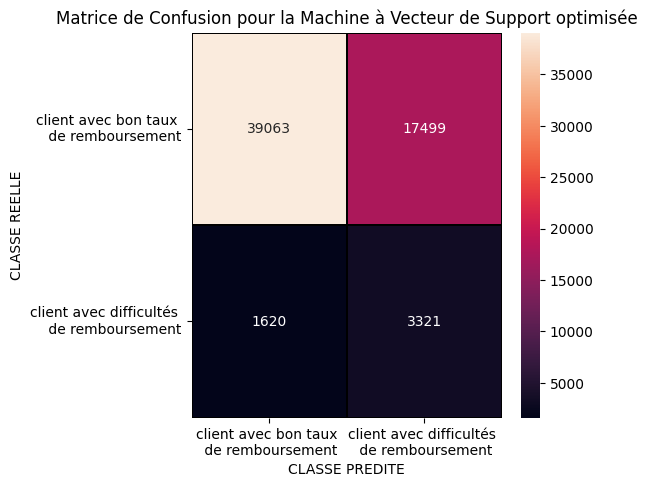

In [ ]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la Machine à Vecteur de Support optimisée')
plt.show()

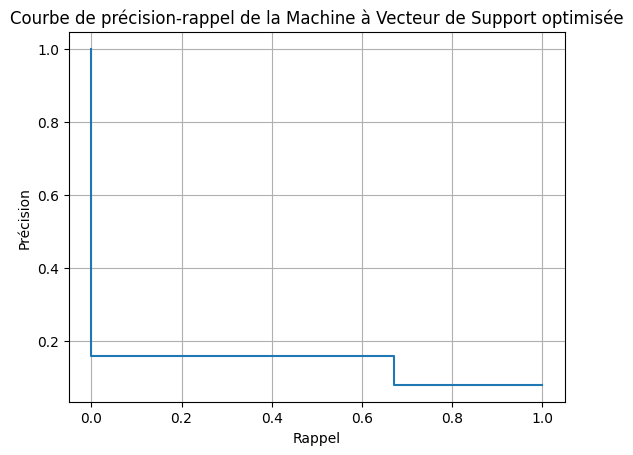

In [ ]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm_gd)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la Machine à Vecteur de Support optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la Machine à Vecteur de Support optimisée')

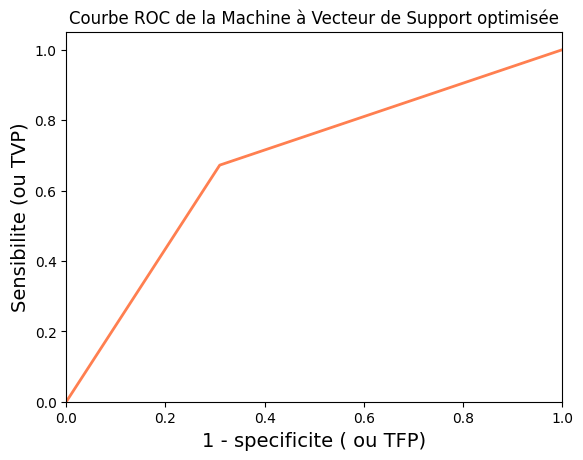

In [ ]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_pred_svm_gd)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la Machine à Vecteur de Support optimisée')

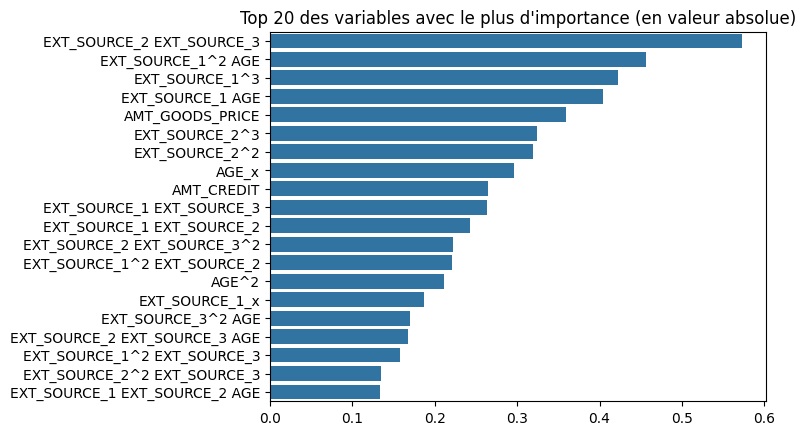

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_svm = (pd.Series(best_model_svm_gs.coef_[0],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_svm, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que les données liées à l'âge et aux EXT_SOURCE ont une importance élevée dans ce modèle optimisé de SVM.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [ ]:
clf = CalibratedClassifierCV(svm)
clf.fit(X_train_eq,y_train_eq)
y_proba_svm_gd = clf.predict_proba(X_test_norm)[:, 1]

In [ ]:
y_proba_svm_gd

array([0.42909068, 0.56805123, 0.34925447, ..., 0.44786801, 0.3681556 ,
       0.48864339])

In [ ]:
# F3 score selon les différents seuils de décision
f3_score_svm=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_proba_svm_gd > i, 1, 0))
  f3_score_svm.append(str(fbeta_score(y_test,preds, beta=3)))


In [ ]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_svm})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


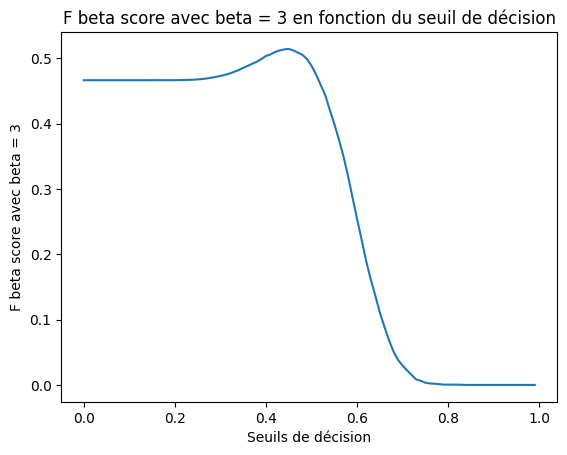

In [ ]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [ ]:
# Cherchons la valeur maximale du F3 score
f3_score_svm_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_svm=df.loc[df['f3_score']==f3_score_svm_max,['abs']]
seuil_opt_svm=seuil_opt_svm.values[0,0]
seuil_opt_svm

0.45

In [ ]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_svm_opt=(y_proba_svm_gd> seuil_opt_svm).astype(int)

In [ ]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_svm_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_svm_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_svm_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_svm_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_svm_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_svm_opt)))

Accuracy Score : 0.48449669121831457
Precision Score : 0.11686898763169949
Recall Score : 0.8261485529245092
F1 Score : 0.2047706237929218
F beta Score (avec beta=3) : 0.5141252188369837
Aire sous la courbe ROC : 0.6404000428778693


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,45.

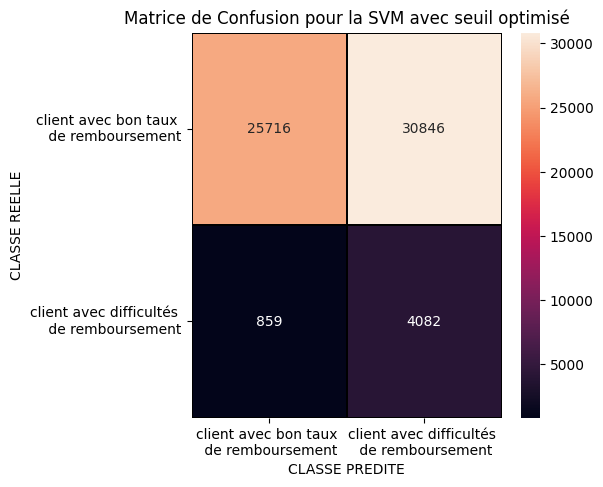

In [ ]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_svm_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM avec seuil optimisé')
plt.show()

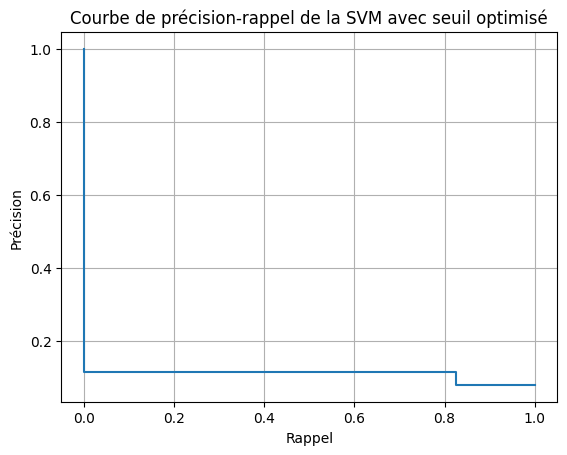

In [ ]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_svm_opt)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM avec seuil optimisé')

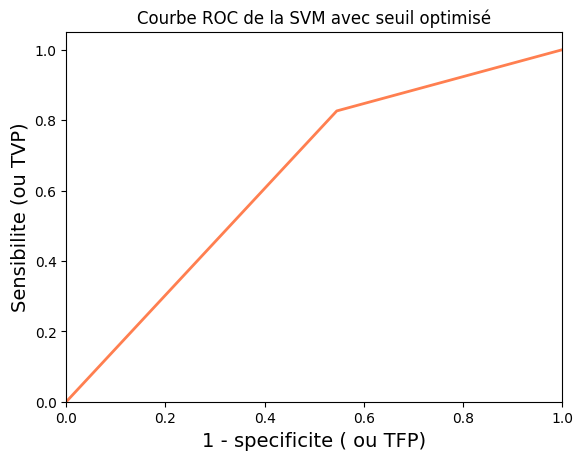

In [ ]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_svm_opt)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM avec seuil optimisé')


### Modèles non-linéaires de SVM à noyau:

 Afin de remédier au problème de l'absence de séparateur linéaire, on utilise un noyau (en anglais kernel) pour déplacer le problème dans un espace de dimension supérieure, éventuellement de dimension infinie.

 Dans ce nouvel espace, appelé espace de redescription, il est alors probable qu'il existe une séparation linéaire.

La fonction noyau choisie doit respecter certaines conditions : être symétrique et semi-définie positive. Cela peut être une fonction noyau polynômial ou exponentielle, ou gaussien(RBF),...

In [ ]:
# Création d'une instance de modèle de SVM de classification à noyau
svm_noy = SVC(tol=1e-5,max_iter=200,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
svm_noy.fit(X_train_eq,y_train_eq)
y_pred_svm_noy = svm_noy.predict(X_test_norm)

In [ ]:
# score de la SVM à noyau
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_noy)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_noy)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_noy)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_noy)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_noy, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_noy)))

Accuracy Score : 0.5965725249174837
Precision Score : 0.09890597876549191
Recall Score : 0.49585104229912974
F1 Score : 0.16491653204092624
F beta Score (avec beta=3) : 0.353841709994223
Aire sous la courbe ROC : 0.5506110697510995


In [ ]:
svm_noy = SVC( tol=1e-5,max_iter=200,random_state=42,probability=True)
params={"C": np.logspace(-5, 5, 10),"kernel":['poly', 'rbf', 'sigmoid'],"gamma": ["scale", "auto"]}

# optimisation des paramètres avec la grid search
grid_svm_noy = GridSearchCV(svm_noy, params,cv=3, n_jobs=-1)
grid_svm_noy.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_noy_gs = grid_svm_noy.best_estimator_

In [ ]:
print(best_model_svm_noy_gs)

SVC(C=0.021544346900318846, gamma='auto', max_iter=200, probability=True,
    random_state=42, tol=1e-05)


In [ ]:
print(grid_svm_noy.best_params_)

{'C': 0.021544346900318846, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
cvres_svm_noy=pd.DataFrame(grid_svm_noy.cv_results_)
cvres_svm_noy

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,115.028273,7.815966,5.832705,0.550747,0.00001,scale,poly,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'poly'}",0.500000,0.500000,0.499925,0.499975,0.000036,54
1,150.091315,2.362616,13.946171,2.463948,0.00001,scale,rbf,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'rbf'}",0.573853,0.580492,0.465827,0.540057,0.052559,15
2,128.066498,8.348319,5.689894,1.012810,0.00001,scale,sigmoid,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'sigm...",0.528063,0.530326,0.477142,0.511844,0.024555,29
3,104.629108,1.115305,6.396830,1.488134,0.00001,auto,poly,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'poly'}",0.500000,0.500000,0.499925,0.499975,0.000036,54
4,162.616310,8.228765,12.240627,0.309365,0.00001,auto,rbf,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'rbf'}",0.573853,0.593920,0.465827,0.544533,0.056254,8
5,119.051543,12.581406,6.614213,0.096730,0.00001,auto,sigmoid,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'sigmo...",0.528214,0.529949,0.475860,0.511341,0.025099,32
6,112.709556,12.109651,5.214075,0.353640,0.000129,scale,poly,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.500000,0.500000,0.500000,0.500000,0.000000,52
7,157.855882,6.653163,20.439357,3.672126,0.000129,scale,rbf,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.573853,0.580492,0.465827,0.540057,0.052559,15
8,124.671603,1.824717,6.273650,0.984616,0.000129,scale,sigmoid,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.528063,0.530326,0.477142,0.511844,0.024555,29
9,113.807286,5.585735,4.811509,0.428248,0.000129,auto,poly,"{'C': 0.0001291549665014884, 'gamma': 'auto', ...",0.500000,0.500000,0.500000,0.500000,0.000000,52


In [ ]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_score")
cvres_svm_noy.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,mean_test_score,std_test_score,rank_test_score
22,160.514569,14.000957,15.120994,2.825345,0.021544,auto,rbf,"{'C': 0.021544346900318846, 'gamma': 'auto', '...",0.579310,0.024501,1
19,153.804054,18.129251,14.757014,4.825211,0.021544,scale,rbf,"{'C': 0.021544346900318846, 'gamma': 'scale', ...",0.577298,0.022722,2
38,124.316613,5.831682,8.764382,2.258563,46.415888,scale,sigmoid,"{'C': 46.41588833612782, 'gamma': 'scale', 'ke...",0.551373,0.020150,3
56,119.340948,8.437328,5.600847,0.859194,100000.0,scale,sigmoid,"{'C': 100000.0, 'gamma': 'scale', 'kernel': 's...",0.549437,0.020288,4
50,133.853998,9.340574,7.648845,0.927358,7742.636827,scale,sigmoid,"{'C': 7742.636826811277, 'gamma': 'scale', 'ke...",0.549437,0.020288,4
41,121.160066,4.738290,7.312618,2.136225,46.415888,auto,sigmoid,"{'C': 46.41588833612782, 'gamma': 'auto', 'ker...",0.548406,0.019299,6
31,168.103992,13.134080,14.373043,3.355121,3.593814,scale,rbf,"{'C': 3.593813663804626, 'gamma': 'scale', 'ke...",0.544936,0.015620,7
10,163.636888,8.837965,14.802328,0.705736,0.000129,auto,rbf,"{'C': 0.0001291549665014884, 'gamma': 'auto', ...",0.544533,0.056254,8
16,146.858955,6.547916,14.316561,3.509428,0.001668,auto,rbf,"{'C': 0.0016681005372000592, 'gamma': 'auto', ...",0.544533,0.056254,8
4,162.616310,8.228765,12.240627,0.309365,0.00001,auto,rbf,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'rbf'}",0.544533,0.056254,8


Les hyperparamètres optimisés correspondent aux paramètres {'C': 0.021544346900318846, 'gamma': 'auto', 'kernel': 'rbf'} et entrainent une maximisation du mean_test_score égal à 0.579310.


Passons à la prédiction avec ce modèle optimisée :

In [ ]:
# prédiction sur les meilleurs hyperparamètres
y_pred_svm_noy_gd = best_model_svm_noy_gs.predict(X_test_norm)
y_prob_svm_noy_gd = best_model_svm_noy_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la SVM à noyau avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_noy_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_noy_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_noy_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_noy_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_noy_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_svm_noy_gd)))

Accuracy Score : 0.6211404321740402
Precision Score : 0.10912884271480883
Recall Score : 0.5187209066990488
F1 Score : 0.18032152531044432
F beta Score (avec beta=3) : 0.3771613567802222
Aire sous la courbe ROC : 0.600310143910155


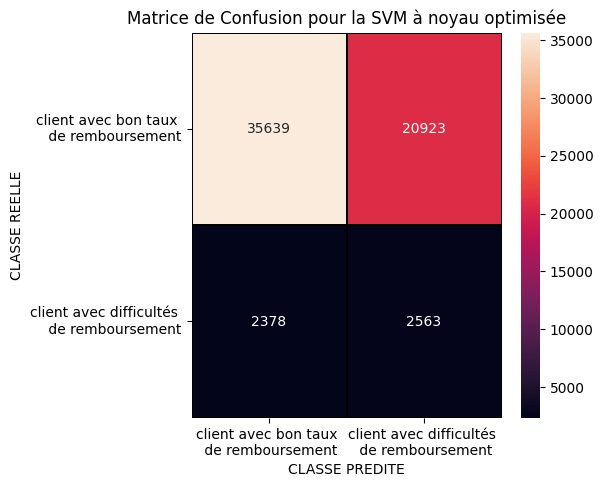

In [ ]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm_noy_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau optimisée')
plt.show()

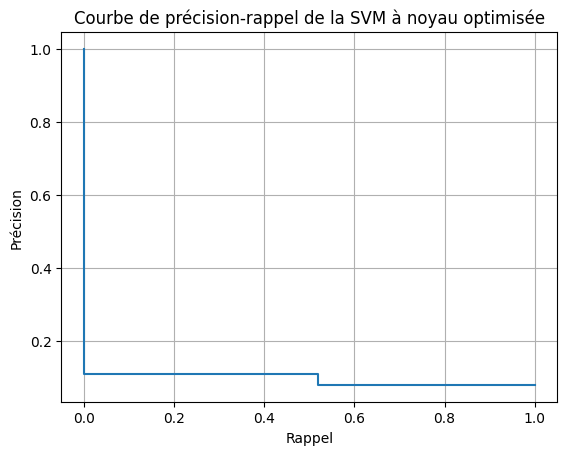

In [ ]:
# Graphique précision-rappel
precision_svm_noy, recall_svm_noy, _ = precision_recall_curve(y_test, y_pred_svm_noy_gd)
disp_svm_noy = PrecisionRecallDisplay(precision=precision_svm_noy, recall=recall_svm_noy)
disp_svm_noy.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM à noyau optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM à noyau optimisée')

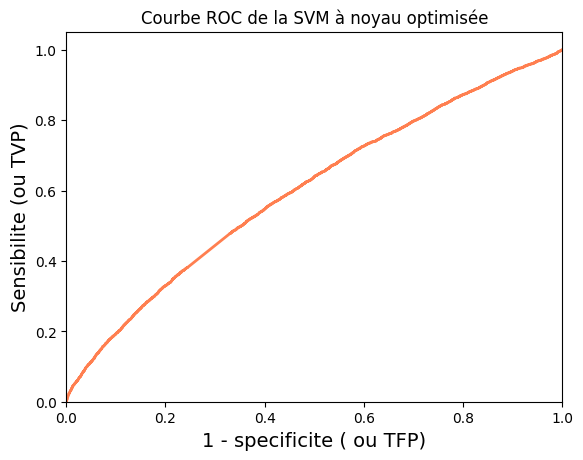

In [ ]:
# Graphique courbe ROC
[fpr_svm_noy, tpr_svm_noy, thr_svm_noy] = metrics.roc_curve(y_test, y_prob_svm_noy_gd)
plt.plot(fpr_svm_noy, tpr_svm_noy, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM à noyau optimisée')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

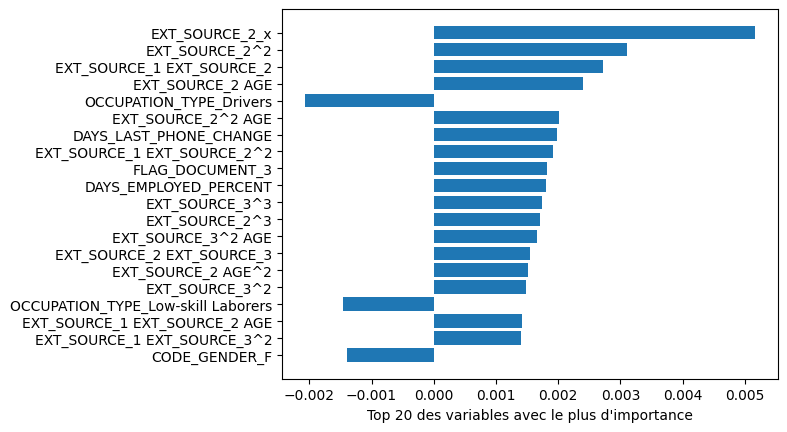

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_svm_noy_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")


Nous pouvons voir que les données EXT_SOURCE_2 ont une importance élevée dans ce modèle optimisé de SVM à noyau RBF.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [ ]:
# F3 score selon les différents seuils de décision
f3_score_svm_noy=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_svm_noy_gd > i, 1, 0))
  f3_score_svm_noy.append(str(fbeta_score(y_test,preds, beta=3)))

In [ ]:
y_prob_svm_noy_gd.shape

(61503,)

In [ ]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_svm_noy})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


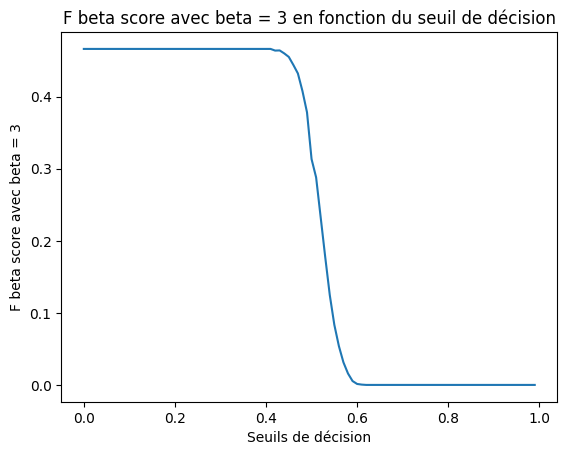

In [ ]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

In [ ]:
# Cherchons la valeur maximale du F3 score
f3_score_svm_noy_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_svm_noy=df.loc[df['f3_score']==f3_score_svm_noy_max,['abs']]
seuil_opt_svm_noy=seuil_opt_svm_noy.values[0,0]
seuil_opt_svm_noy

0.41

In [ ]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_svm_noy_opt=(y_prob_svm_noy_gd> seuil_opt_svm_noy).astype(int)

In [ ]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_svm_noy_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_svm_noy_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_svm_noy_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_svm_noy_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_svm_noy_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_svm_noy_opt)))

Accuracy Score : 0.08035380387948556
Precision Score : 0.08033885076908068
Recall Score : 1.0
F1 Score : 0.14872898574718177
F beta Score (avec beta=3) : 0.46625963707051926
Aire sous la courbe ROC : 0.5000088398571478


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,41.

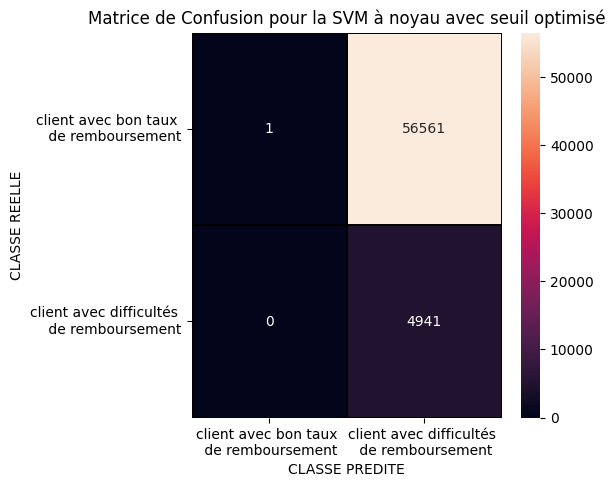

In [ ]:
# Graphique de la matrice de confusion
cm_svm_noy = confusion_matrix(y_test, y_svm_noy_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_noy, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau avec seuil optimisé')
plt.show()

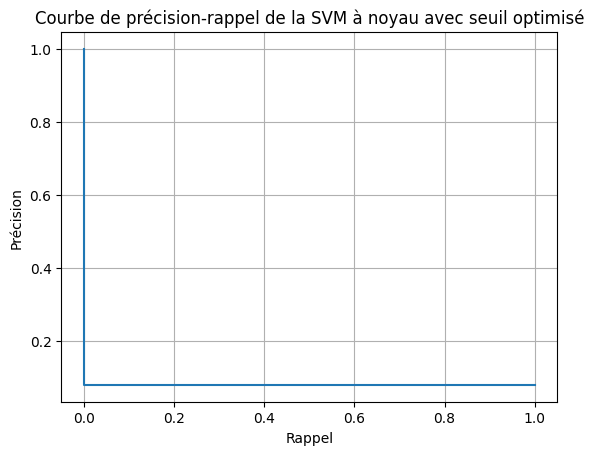

In [ ]:
# Graphique précision-rappel
precision_svm_noy, recall_svm_noy, _ = precision_recall_curve(y_test, y_svm_noy_opt)
disp_svm_noy = PrecisionRecallDisplay(precision=precision_svm_noy, recall=recall_svm_noy)
disp_svm_noy.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM à noyau avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM à noyau avec seuil optimisé')

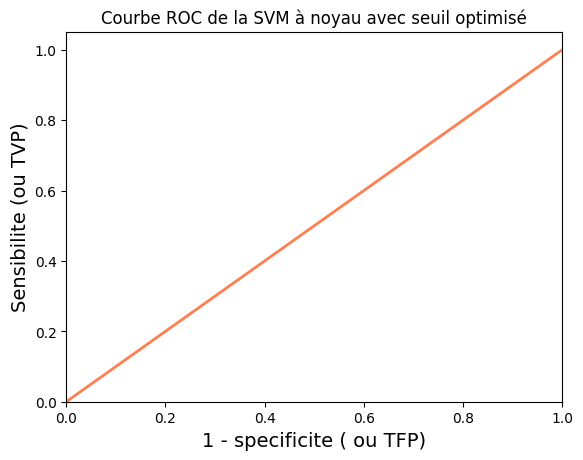

In [ ]:
# Graphique courbe ROC
[fpr_svm_noy, tpr_svm_noy, thr_svm_noy] = metrics.roc_curve(y_test, y_svm_noy_opt)
plt.plot(fpr_svm_noy, tpr_svm_noy, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM à noyau avec seuil optimisé')

### Modèles de réseaux de neurones:


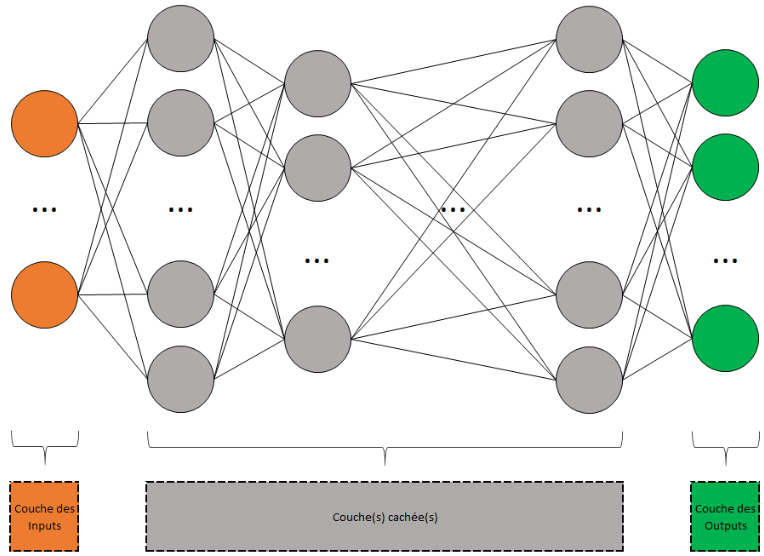

Dans un réseau, le neurone est une unité qui reçoit l'information, procède à des calculs simples, et la transmet à une autre unité. On distingue trois types de neurones dans un réseau artificiel :
- Les neurones d'entrées qui reçoivent les données du monde extérieur (couche d'entrée) ;
- Les neurones de traitement (couche cachée) ;
- Les neurones de sorties (couche de sortie).

Il permet d'apprendre des modèles de régression (la fonction d'activation est l'identité), de classification binaire (la fonction d'activation est la fonction logistique) ou de classification multi-classe (la fonction d'activation est la fonction softmax).

Chaque connexion a un poids spécifique qui influence la transmission de l'information d'une unité à une autre. Les informations provenant d'une connexion avec un poids important seront ainsi dominantes à l'entrée du neurone suivant, comparativement à celles provenant de connexions à poids faible. Ces dernières ne sont cependant pas ignorées lors du traitement de l'information. Les poids sont mis à jour de façon itérative grâce à l'algorithme du gradient.

L'entraînement de ces réseaux se fait par rétro-propagation. Attention, cet algorithme ne converge pas nécessairement, et pas nécessairement vers la solution optimale ! Plus il y a de paramètres, plus il faut de données pour pouvoir apprendre les valeurs de ces paramètres sans risquer le sur-apprentissage.

In [ ]:
#Création d'une instance de réseau de neurones.

#Nous utilisons la fonction Sequential() qui est approprié pour notre problème(cf bibliothèque Keras: https://keras.io/guides/sequential_model/)
neuron= tf.keras.Sequential()
#On indique à notre modèle la dimension des données d'entrées qui correspond au nombre de colonnes de X_train, c'est à dire 276.
neuron.add(tf.keras.layers.InputLayer(input_shape=[276]))
#Première couche de notre réseau de neurones avec 276 perceptrons.
#La fonction sigmoide est particulièrement indiqué pour les problèmes de classification.
neuron.add(tf.keras.layers.Dense(276, input_dim=2, activation='sigmoid'))
#Seconde couche car nous sommes dans un problème non linéaire
neuron.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#Ici, nous pouvons ajouter des paramètres à notre modèle. Il faut juste retenir que "accuracy" permet d'avoir
#la précision de notre modèle et est particulièrement indiqué pour les problèmes de classification.

neuron.compile(metrics=[tf.keras.metrics.Accuracy(name='my_accuracy'), tf.keras.metrics.Precision(name='my_precision'),tf.keras.metrics.Recall(name='my_recall'),tf.keras.metrics.F1Score( name="my_f1_score"),tf.keras.metrics.FBetaScore( beta=3.0, name="my_fbeta_score"),tf.keras.metrics.AUC(name='my_auc')],
                  loss="binary_crossentropy",
                  optimizer="adam")

In [ ]:
#"summary" permet d'avoir les paramètres qui la compose ainsi que les dimensions à la sortie de chaque couche
neuron.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 276)                 │          76,452 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             277 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,729 (299.72 KB)

 Trainable params: 76,729 (299.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# On entraine le modèle de réseau de neurone
history = neuron.fit(X_train_eq,
                    y_train_eq,
                    epochs = 50,
                    batch_size = 200,
                    verbose = 1)

Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6333 - my_accuracy: 0.0000e+00 - my_auc: 0.7077 - my_f1_score: 0.6613 - my_fbeta_score: 0.9071 - my_precision: 0.6470 - my_recall: 0.6179
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6019 - my_accuracy: 0.0000e+00 - my_auc: 0.7393 - my_f1_score: 0.6672 - my_fbeta_score: 0.9093 - my_precision: 0.6732 - my_recall: 0.6900
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5936 - my_accuracy: 0.0000e+00 - my_auc: 0.7481 - my_f1_score: 0.6716 - my_fbeta_score: 0.9109 - my_precision: 0.6798 - my_recall: 0.7060
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5932 - my_accuracy: 0.0000e+00 - my_auc: 0.7485 - my_f1_score: 0.6658 - my_fbeta_score: 0.9088 - my_precision: 0.6795 - my_recall: 0.6930
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5918 - my_accuracy: 0.0000e+00 - my_auc: 0.7500 - my_f1_score: 0.6650 - my_fbeta_score: 0.9085 - my_precision: 0.6816 - my_recall: 0.6944


In [ ]:
y_pred_neuron = neuron.predict(X_test_norm)

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
#On évalue notre modèle
result = neuron.evaluate(X_test_norm, y_test, verbose=1)

print('Accuracy Score : ' + str(result[1]))
print('Precision Score : ' + str(result[2]))
print('Recall Score : ' + str(result[3]))
print('F1 Score : ' + str(result[4]))
print('F beta Score (avec beta=3) : ' + str(result[5]))
print('Aire sous la courbe ROC : ' +str(result[6]))


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8582 - my_accuracy: 0.0000e+00 - my_auc: 0.6902 - my_f1_score: 0.1485 - my_fbeta_score: 0.4657 - my_precision: 0.1319 - my_recall: 0.6780
Accuracy Score : 0.0
Precision Score : 0.13059361279010773
Recall Score : 0.665654718875885
F1 Score : 0.14874911308288574
F beta Score (avec beta=3) : 0.4662992060184479
Aire sous la courbe ROC : 0.6868841648101807


In [ ]:
# optimisation des paramètres avec la grid search
batch_size = [50,100, 100,150,200]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasClassifier(model=neuron, verbose=0)

grid_neuron = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_neuron.fit(X_train_eq,y_train_eq)
#récupération des meilleurs hyperparamètres
best_model_neuron_gs = grid_neuron.best_estimator_

In [ ]:
print(best_model_neuron_gs)

KerasClassifier(
	model=<Sequential name=sequential, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=200
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)


In [ ]:
cvres_neuron=pd.DataFrame(grid_neuron.cv_results_)
cvres_neuron

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,128.251435,5.532394,7.224635,0.571340,50,10,"{'batch_size': 50, 'epochs': 10}",0.829059,0.831095,0.832830,0.830995,0.001542,5
1,599.145169,10.726492,8.789731,0.719950,50,50,"{'batch_size': 50, 'epochs': 50}",0.751735,0.750226,0.743814,0.748592,0.003434,11
2,1260.849555,14.635393,9.569856,0.781830,50,100,"{'batch_size': 50, 'epochs': 100}",0.735139,0.715600,0.735667,0.728802,0.009337,15
3,97.762843,10.698375,5.591614,0.806199,100,10,"{'batch_size': 100, 'epochs': 10}",0.855537,0.858630,0.858404,0.857524,0.001408,3
4,378.313629,10.367814,5.598424,0.221956,100,50,"{'batch_size': 100, 'epochs': 50}",0.768558,0.768482,0.764107,0.767049,0.002081,9
5,697.452634,1.948218,5.883312,0.530126,100,100,"{'batch_size': 100, 'epochs': 100}",0.740042,0.741249,0.743739,0.741677,0.001539,14
6,96.212260,6.099448,6.026930,0.601924,100,10,"{'batch_size': 100, 'epochs': 10}",0.857649,0.860516,0.848974,0.855713,0.004907,4
7,334.629850,4.721007,6.396194,0.358291,100,50,"{'batch_size': 100, 'epochs': 50}",0.765842,0.770519,0.766672,0.767678,0.002038,8
8,724.314852,2.442192,5.690273,0.565131,100,100,"{'batch_size': 100, 'epochs': 100}",0.741702,0.743588,0.741853,0.742381,0.000856,13
9,76.853098,0.863676,4.604585,1.624304,150,10,"{'batch_size': 150, 'epochs': 10}",0.868890,0.870625,0.869342,0.869619,0.000735,2


In [ ]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_score")
cvres_neuron.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,mean_test_score,std_test_score,rank_test_score
12,63.972236,2.179489,3.714185,0.170815,200,10,"{'batch_size': 200, 'epochs': 10}",0.881236,0.002015,1
9,76.853098,0.863676,4.604585,1.624304,150,10,"{'batch_size': 150, 'epochs': 10}",0.869619,0.000735,2
3,97.762843,10.698375,5.591614,0.806199,100,10,"{'batch_size': 100, 'epochs': 10}",0.857524,0.001408,3
6,96.212260,6.099448,6.026930,0.601924,100,10,"{'batch_size': 100, 'epochs': 10}",0.855713,0.004907,4
0,128.251435,5.532394,7.224635,0.571340,50,10,"{'batch_size': 50, 'epochs': 10}",0.830995,0.001542,5
13,212.139493,3.352843,2.819918,0.721506,200,50,"{'batch_size': 200, 'epochs': 50}",0.789328,0.001760,6
10,264.274666,0.831424,4.849332,0.487303,150,50,"{'batch_size': 150, 'epochs': 50}",0.780552,0.002126,7
7,334.629850,4.721007,6.396194,0.358291,100,50,"{'batch_size': 100, 'epochs': 50}",0.767678,0.002038,8
4,378.313629,10.367814,5.598424,0.221956,100,50,"{'batch_size': 100, 'epochs': 50}",0.767049,0.002081,9
14,273.048630,7.882190,1.065045,0.158160,200,100,"{'batch_size': 200, 'epochs': 100}",0.754753,0.003143,10


Les hyperparamètres optimisés correspondent au couple {'batch_size': 200, 'epochs': 10} et entrainent une maximisation du mean_test_score égal à 0.881991.


Passons à la prédiction avec ce modèle optimisée :

In [ ]:
# prédiction sur les meilleurs hyperparamètres
y_pred_neuron_gd = best_model_neuron_gs.predict(X_test_norm)
y_prob_neuron_gd = best_model_neuron_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_neuron_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_neuron_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_neuron_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_neuron_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_neuron_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_neuron_gd)))

Accuracy Score : 0.6338877778319757
Precision Score : 0.1279109154035058
Recall Score : 0.6114146933819065
F1 Score : 0.21156202948282501
F beta Score (avec beta=3) : 0.44369703467622307
Aire sous la courbe ROC : 0.6236328090154821


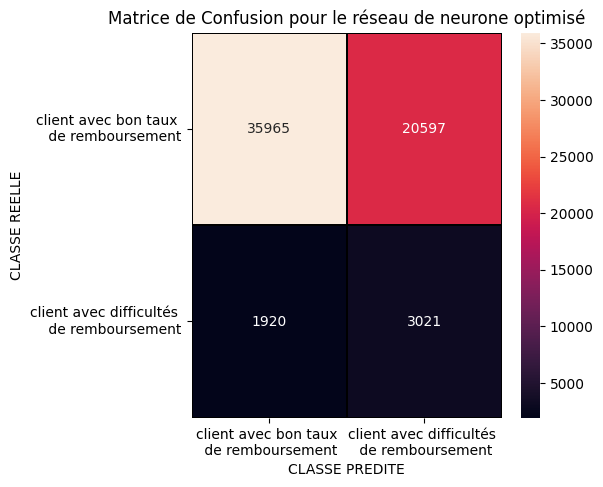

In [ ]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_pred_neuron_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurone optimisé')
plt.show()

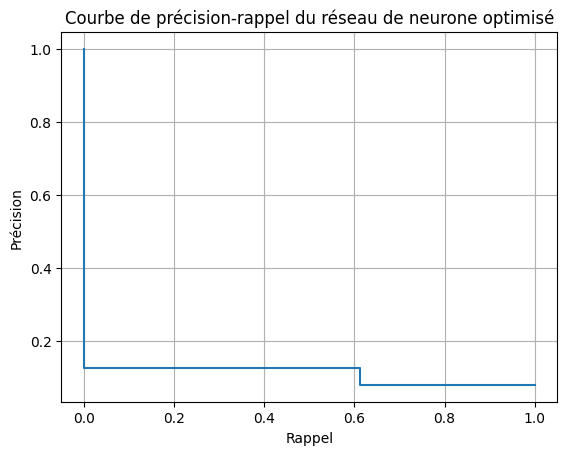

In [ ]:
# Graphique précision-rappel
precision_neuron, recall_neuron, _ = precision_recall_curve(y_test, y_pred_neuron_gd)
disp_neuron = PrecisionRecallDisplay(precision=precision_neuron, recall=recall_neuron)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du réseau de neurone optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du réseau de neurone optimisé')

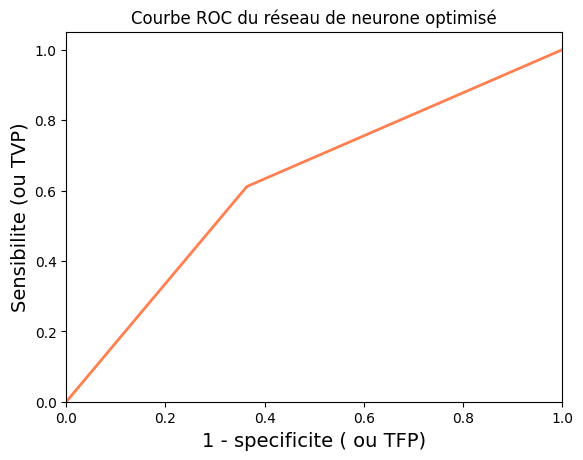

In [ ]:
# Graphique courbe ROC
[fpr_neuron, tpr_neuron, thr_neuron] = metrics.roc_curve(y_test, y_pred_neuron_gd)
plt.plot(fpr_neuron, tpr_neuron, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du réseau de neurone optimisé')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

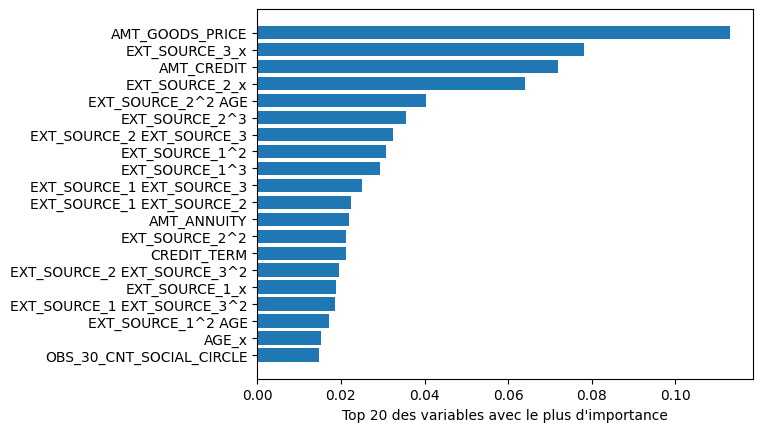

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance_neuron = permutation_importance(best_model_neuron_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx_neuron = abs(perm_importance_neuron.importances_mean).argsort()
plt.barh(features[sorted_idx_neuron[-20:]], perm_importance_neuron.importances_mean[sorted_idx_neuron[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Nous pouvons voir que les données "AMT_GOODS_PRICE", "AMT_CREDIT" et EXT_SOURCE ont une importance élevée dans ce modèle optimisé de réseau de neurones.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [ ]:
# F3 score selon les différents seuils de décision
f3_score_neuron=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_neuron_gd > i, 1, 0))
  f3_score_neuron.append(str(fbeta_score(y_test,preds, beta=3)))

In [ ]:
y_prob_neuron_gd.shape

(61503,)

In [ ]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_neuron})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


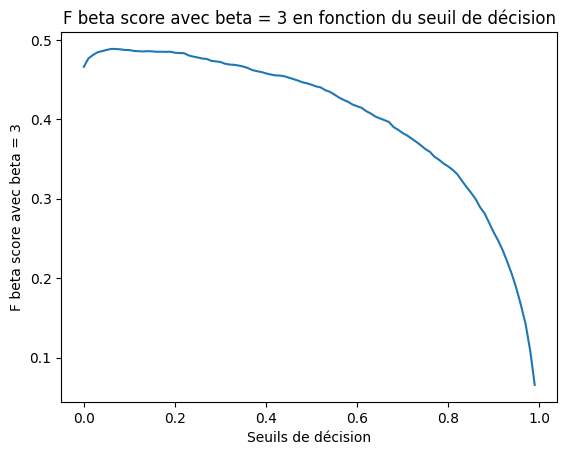

In [ ]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

In [ ]:
# Cherchons la valeur maximale du F3 score
f3_score_neuron_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_neuron=df.loc[df['f3_score']==f3_score_neuron_max,['abs']]
seuil_opt_neuron=seuil_opt_neuron.values[0,0]
seuil_opt_neuron

0.06

In [ ]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_neuron_opt=(y_prob_neuron_gd> seuil_opt_neuron).astype(int)

In [ ]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_neuron_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_neuron_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_neuron_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_neuron_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_neuron_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_neuron_opt)))

Accuracy Score : 0.2966196770889225
Precision Score : 0.09484235234409694
Recall Score : 0.9077109896782027
F1 Score : 0.1717403790924756
F beta Score (avec beta=3) : 0.4887857189563853
Aire sous la courbe ROC : 0.5754742494800263


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,06.

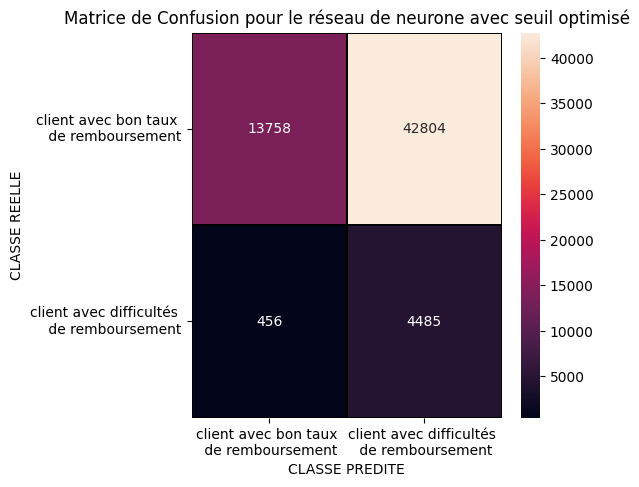

In [ ]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_neuron_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurone avec seuil optimisé')
plt.show()

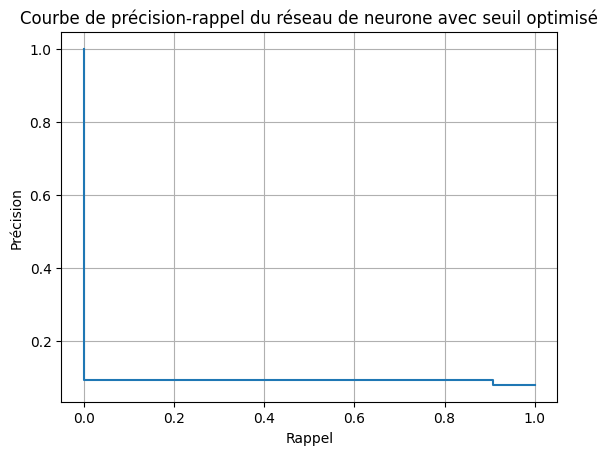

In [ ]:
# Graphique précision-rappel
precision_neuron, recall_neuron, _ = precision_recall_curve(y_test, y_neuron_opt)
disp_neuron = PrecisionRecallDisplay(precision=precision_neuron, recall=recall_neuron)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du réseau de neurone avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du réseau de neurone avec seuil optimisé')

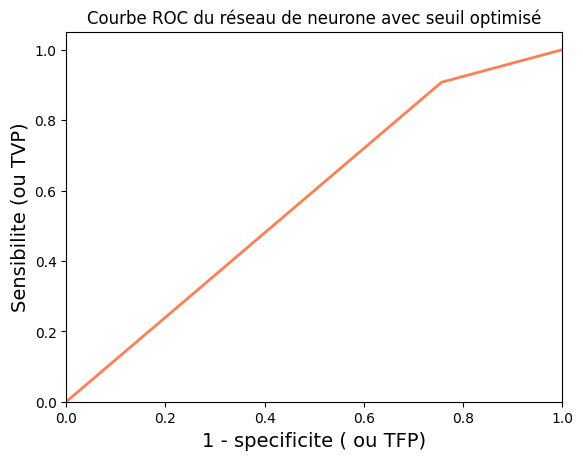

In [ ]:
# Graphique courbe ROC
[fpr_neuron, tpr_neuron, thr_neuron] = metrics.roc_curve(y_test, y_neuron_opt)
plt.plot(fpr_neuron, tpr_neuron, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du réseau de neurone avec seuil optimisé')

### Modèles ensembliste de forêts aléatoires (Random Forest):


La base du calcul repose sur l'apprentissage par arbres de décision partiellement indépendants les uns des autres.

Pour chaque arbre à créer :

- On crée un échantillon en tirant avec remise autant d'observations que le jeu de données inital (technique connue sous le nom de  bagging, aussi appelé bootstrap aggregating ),
- Sur toutes les variables, on n'en retient qu'un plus petit nombre au hasard.
- On entraîne un arbre de décision à partir de l'échantillon créé en ne tenant compte que des variables sélectionnées. On limite la croissance de l'arbre de décision par validation croisée.

In [ ]:
# Création d'une instance de modèle de forêt aléatoire
rfc = RandomForestClassifier(n_estimators=500,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
rfc.fit(X_train_eq,y_train_eq)
y_pred_rfc = rfc.predict(X_test_norm)

In [ ]:
# score de la forêt aléatoire
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_rfc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_rfc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_rfc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_rfc)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_rfc, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_rfc)))

Accuracy Score : 0.6897874900411362
Precision Score : 0.15837038468973516
Recall Score : 0.6632260675976523
F1 Score : 0.25568602972730464
F beta Score (avec beta=3) : 0.5029081812740751
Aire sous la courbe ROC : 0.6776669215679999


In [ ]:
rfc = RandomForestClassifier( random_state=42)
params={"max_depth": [None] + list(range(2, 20, 3)),"max_features": ["auto", "sqrt", "log2"],"n_estimators":[100,500,1000]}

# optimisation des paramètres avec la grid search
grid_rfc = GridSearchCV(rfc, params,cv=3, n_jobs=-1)
grid_rfc.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_rfc_gs = grid_rfc.best_estimator_

In [ ]:
print(best_model_rfc_gs)

RandomForestClassifier(max_depth=17, max_features='auto', n_estimators=1000,
                       random_state=42)


In [ ]:
print(grid_rfc.best_params_)

{'max_depth': 17, 'max_features': 'auto', 'n_estimators': 1000}


In [ ]:
cvres_rfc=pd.DataFrame(grid_rfc.cv_results_)
cvres_rfc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,125.742527,20.301482,2.066346,0.139523,None,auto,100,"{'max_depth': None, 'max_features': 'auto', 'n...",0.678636,0.675920,0.670338,0.674965,0.003454,34
1,673.006522,17.773780,9.667801,0.557139,None,auto,500,"{'max_depth': None, 'max_features': 'auto', 'n...",0.677052,0.682785,0.670791,0.676876,0.004898,20
2,1306.606567,27.284278,21.302569,1.811735,None,auto,1000,"{'max_depth': None, 'max_features': 'auto', 'n...",0.678938,0.682408,0.671696,0.677681,0.004463,11
3,139.982310,9.970888,1.982915,0.077273,None,sqrt,100,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.678636,0.675920,0.670338,0.674965,0.003454,34
4,677.257245,8.035178,9.842414,0.892192,None,sqrt,500,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.677052,0.682785,0.670791,0.676876,0.004898,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,565.559757,26.660212,9.672041,1.039236,17,sqrt,500,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.678561,0.681880,0.673280,0.677907,0.003541,7
59,975.957068,18.579130,10.680530,1.386390,17,sqrt,1000,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.678410,0.682710,0.674713,0.678611,0.003268,1
60,70.180963,8.840079,2.229693,0.464496,17,log2,100,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.679617,0.682861,0.672827,0.678435,0.004180,3
61,294.666034,14.680002,8.097998,0.127118,17,log2,500,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.677731,0.682333,0.672752,0.677605,0.003912,15


In [ ]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_score")
cvres_rfc.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score
56,1065.911280,23.674231,15.673312,1.467619,17,auto,1000,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.678611,0.003268,1
59,975.957068,18.579130,10.680530,1.386390,17,sqrt,1000,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.678611,0.003268,1
60,70.180963,8.840079,2.229693,0.464496,17,log2,100,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.678435,0.004180,3
7,391.074875,7.785191,17.339751,0.183639,None,log2,500,"{'max_depth': None, 'max_features': 'log2', 'n...",0.678435,0.003334,3
47,987.183152,41.555196,15.149798,0.899598,14,auto,1000,"{'max_depth': 14, 'max_features': 'auto', 'n_e...",0.678183,0.003026,5
50,983.284273,43.170806,17.082897,3.398122,14,sqrt,1000,"{'max_depth': 14, 'max_features': 'sqrt', 'n_e...",0.678183,0.003026,5
55,557.397892,3.390311,10.332589,1.836070,17,auto,500,"{'max_depth': 17, 'max_features': 'auto', 'n_e...",0.677907,0.003541,7
58,565.559757,26.660212,9.672041,1.039236,17,sqrt,500,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.677907,0.003541,7
62,467.351502,10.755248,10.679921,2.123971,17,log2,1000,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.677831,0.004391,9
53,503.422387,41.125967,16.442561,1.290479,14,log2,1000,"{'max_depth': 14, 'max_features': 'log2', 'n_e...",0.677806,0.002843,10


Les hyperparamètres optimisés correspondent au deux couple de paramètres suivants {'max_depth': 17,'n_estimators':1000, 'max_features': 'auto' ou 'sqrt'} et entrainent une maximisation du mean_test_score égal à 0.678611.

Cependant la combinaison avec 'n_estimators'= 'sqrt' est plus rapide.

La combinaison {'max_depth': 17,'n_estimators':100, 'max_features': 'log2'} est également à considérer car elle est beaucoup plus rapide pour un résultat quasiment similaire.

Passons à la prédiction avec ce modèle optimisée :

In [ ]:
# prédiction sur les meilleurs hyperparamètres
y_pred_rfc_gd = best_model_rfc_gs.predict(X_test_norm)
y_prob_rfc_gd = best_model_rfc_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la forêt aléatoire avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_rfc_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_rfc_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_rfc_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_rfc_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_rfc_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_rfc_gd)))

Accuracy Score : 0.68362518901517
Precision Score : 0.1562396400663036
Recall Score : 0.667678607569318
F1 Score : 0.2532238256063863
F beta Score (avec beta=3) : 0.503019029031471
Aire sous la courbe ROC : 0.7386523303040659


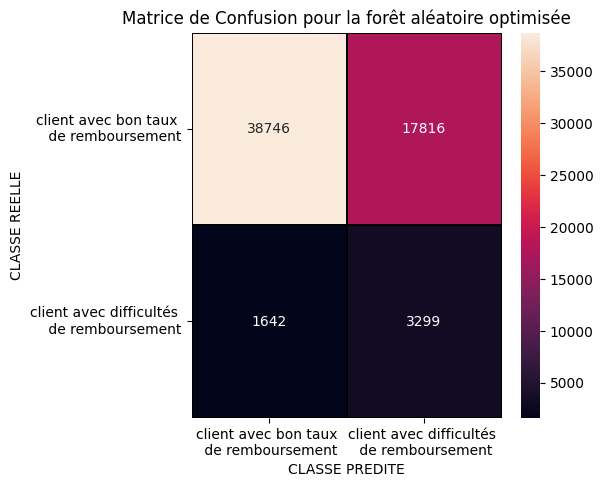

In [ ]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_pred_rfc_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire optimisée')
plt.show()

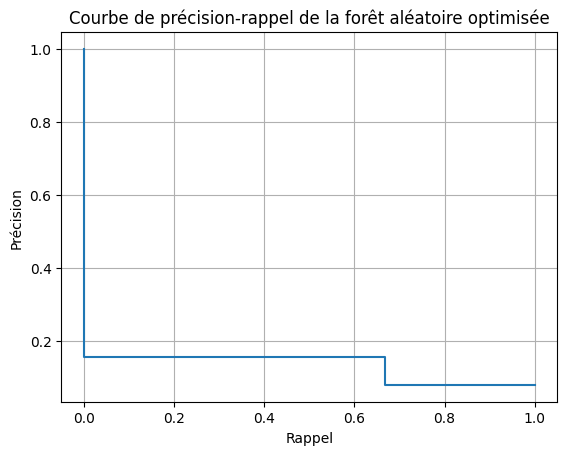

In [ ]:
# Graphique précision-rappel
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_pred_rfc_gd)
disp_rfc = PrecisionRecallDisplay(precision=precision_rfc, recall=recall_rfc)
disp_rfc.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la forêt aléatoire optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la forêt aléatoire optimisée')

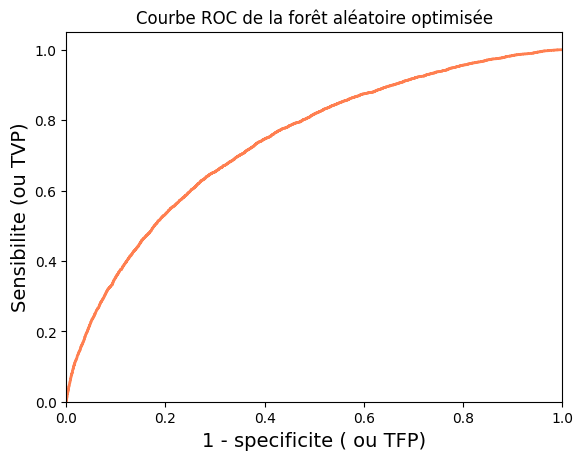

In [ ]:
# Graphique courbe ROC
[fpr_rfc, tpr_rfc, thr_rfc] = metrics.roc_curve(y_test, y_prob_rfc_gd)
plt.plot(fpr_rfc, tpr_rfc, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la forêt aléatoire optimisée')

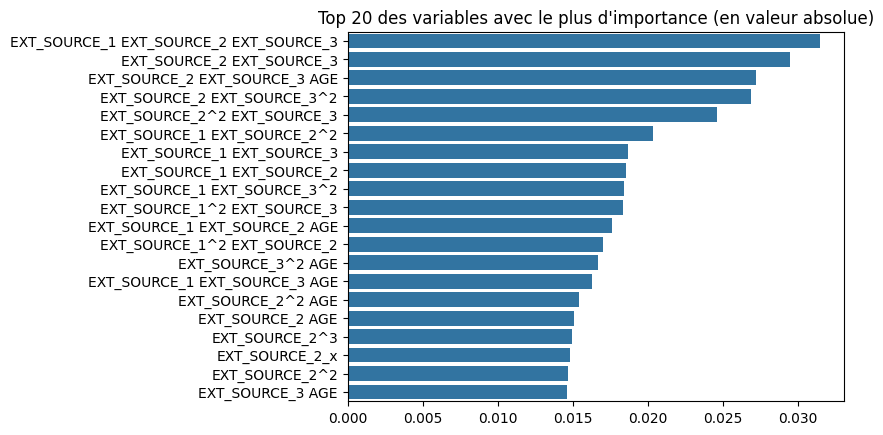

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_rfc = (pd.Series(best_model_rfc_gs.feature_importances_,X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_rfc, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que les combinaisons créées avec les données EXT_SOURCE et AGE ont une importance élevée dans ce modèle optimisé de forêt aléatoire.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [ ]:
# F3 score selon les différents seuils de décision
f3_score_rfc=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_rfc_gd > i, 1, 0))
  f3_score_rfc.append(str(fbeta_score(y_test,preds, beta=3)))


In [ ]:
y_prob_rfc_gd.shape

(61503,)

In [ ]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_rfc})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


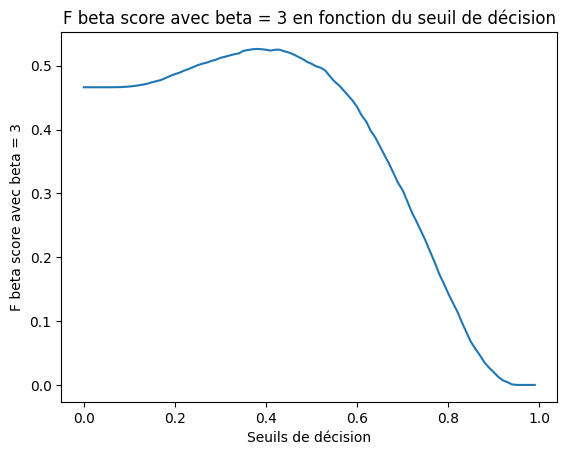

In [ ]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

In [ ]:
# Cherchons la valeur maximale du F3 score
f3_score_rfc_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_rfc=df.loc[df['f3_score']==f3_score_rfc_max,['abs']]
seuil_opt_rfc=seuil_opt_rfc.values[0,0]
seuil_opt_rfc

0.38

In [ ]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_rfc_opt=(y_prob_rfc_gd> seuil_opt_rfc).astype(int)

In [ ]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_rfc_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_rfc_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_rfc_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_rfc_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_rfc_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_rfc_opt)))

Accuracy Score : 0.4974879274181747
Precision Score : 0.12095997197162127
Recall Score : 0.8384942319368549
F1 Score : 0.2114206981016534
F beta Score (avec beta=3) : 0.5262957317073171
Aire sous la courbe ROC : 0.6530966969591986


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,38.

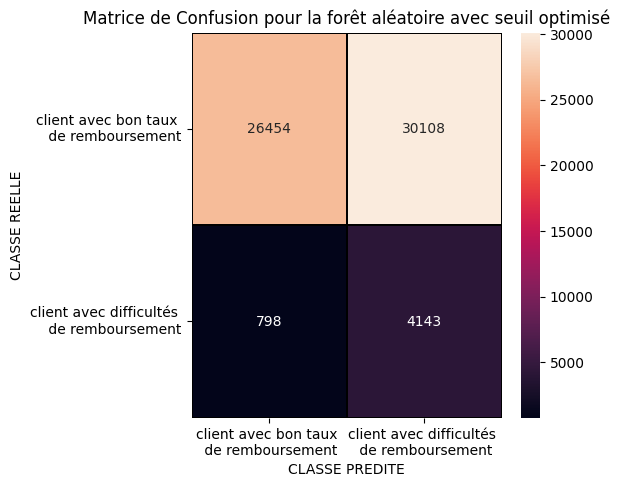

In [ ]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_rfc_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire avec seuil optimisé')
plt.show()

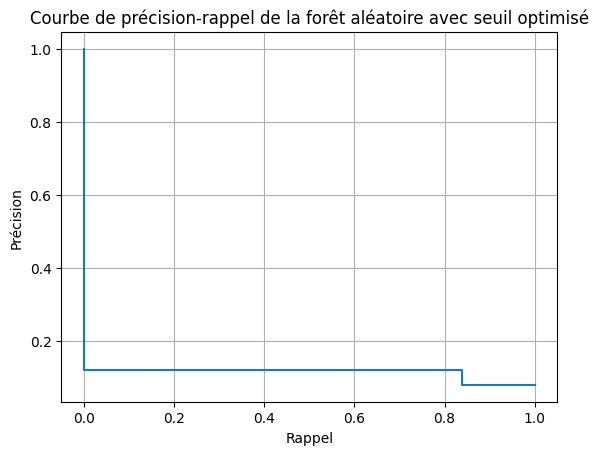

In [ ]:
# Graphique précision-rappel
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_rfc_opt)
disp_rfc = PrecisionRecallDisplay(precision=precision_rfc, recall=recall_rfc)
disp_rfc.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la forêt aléatoire avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la forêt aléatoire avec seuil optimisé')

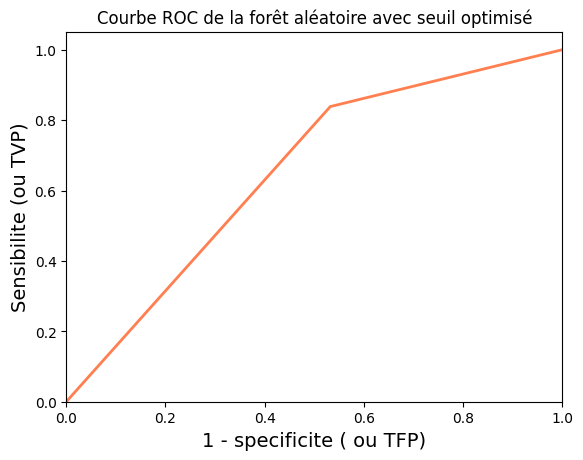

In [ ]:
# Graphique courbe ROC
[fpr_rfc, tpr_rfc, thr_rfc] = metrics.roc_curve(y_test, y_rfc_opt)
plt.plot(fpr_rfc, tpr_rfc, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la forêt aléatoire avec seuil optimisé')

In [ ]:
#  Sélection du seuil pour diminuer le nombre de variables si nombre de lignes peu important et risque d'overfitting

# from sklearn.feature_selection import SelectFromModel
# select = SelectFromModel(rfc.fit(X_train_eq,y_train_eq), prefit=True, threshold=0.01)
# X_train2 = select.transform(X_train_eq)
# print(X_train2.shape)

# avec boucle
# selectbislist=[]
# Xtrainbis=[]
# for i in [x / 1000.0 for x in range(5, 26, 5)]   :
#   selectbis=SelectFromModel(best_model_rfc_gs, prefit=True, threshold=i)
#   selectbislist.append(selectbis)
#   temp=selectbis.transform(X_train_eq)
#   Xtrainbis.append(temp)

### Modèles ensembliste séquentiel du XGBoost:

Le boosting va produire des modèles qui sont très dépendants les uns des autres, contrairement au principe du bagging. En effet les modèles sont entraînés itérativement comme suit :

- La première étape consiste à créer un premier modèle de base partir d'un algorithme choisi. Il est entraîné sur les données. Au début, on attribue des poids égaux à toutes les observations. À partir des résultats obtenus de ce modèle, si une observation est mal classée, cela augmente son poids.

- Ensuite, un second modèle est construit pour tenter de corriger les erreurs présentes dans le premier modèle. Il est entraîné à l'aide des données pondérées obtenues dans la première étape. Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.

- Les prédictions du dernier modèle ajouté seront les prédictions globales pondérées fournies par les anciens modèles d’arbres.


In [ ]:
# Création d'une instance de modèle de XGBoost
bst = XGBClassifier( max_depth=20, learning_rate=1, objective='binary:logistic')

# On entraîne ce modèle sur les données d'entrainement
bst.fit(X_train_eq,y_train_eq)
y_pred_bst = bst.predict(X_test_norm)

In [ ]:
# score du XGBoost
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_bst)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_bst)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_bst)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_bst)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_bst, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_bst)))

Accuracy Score : 0.6570248605759069
Precision Score : 0.14211016085434483
Recall Score : 0.6490588949605343
F1 Score : 0.23316853279046093
F beta Score (avec beta=3) : 0.4783996658511844
Aire sous la courbe ROC : 0.6533898130967588


In [ ]:
bst = XGBClassifier( objective='binary:logistic', random_state=42)
params={"learning_rate" : [0.1,0.5,1],"max_depth": [None] + list(range(2, 10, 2))}

# optimisation des paramètres avec la grid search
grid_bst = GridSearchCV(bst, params,cv=3, n_jobs=-1)
grid_bst.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_bst_gs = grid_bst.best_estimator_

In [ ]:
print(best_model_bst_gs)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [ ]:
print(grid_bst.best_params_)

{'learning_rate': 0.1, 'max_depth': None}


In [ ]:
cvres_bst=pd.DataFrame(grid_bst.cv_results_)
cvres_bst

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,33.019098,4.804037,0.878825,0.210070,0.1,None,"{'learning_rate': 0.1, 'max_depth': None}",0.691385,0.695383,0.688518,0.691762,0.002815,1
1,16.039205,1.568478,0.596349,0.062686,0.1,2,"{'learning_rate': 0.1, 'max_depth': 2}",0.683238,0.691159,0.681503,0.685300,0.004203,6
2,25.333145,4.190930,0.720247,0.232468,0.1,4,"{'learning_rate': 0.1, 'max_depth': 4}",0.687387,0.696967,0.687161,0.690505,0.004571,4
3,37.610479,6.144958,0.964994,0.245217,0.1,6,"{'learning_rate': 0.1, 'max_depth': 6}",0.691385,0.695383,0.688518,0.691762,0.002815,1
4,50.281132,3.989457,0.926533,0.296335,0.1,8,"{'learning_rate': 0.1, 'max_depth': 8}",0.688518,0.687387,0.683162,0.686356,0.002305,5
5,30.913904,4.892674,0.636503,0.039345,0.5,None,"{'learning_rate': 0.5, 'max_depth': None}",0.661210,0.662643,0.658494,0.660783,0.001721,9
6,19.232267,3.541760,0.496833,0.022770,0.5,2,"{'learning_rate': 0.5, 'max_depth': 2}",0.686783,0.695836,0.692290,0.691636,0.003724,3
7,18.665446,1.452269,0.753695,0.321254,0.5,4,"{'learning_rate': 0.5, 'max_depth': 4}",0.672375,0.682182,0.677127,0.677228,0.004004,8
8,28.018408,1.416856,0.674205,0.056965,0.5,6,"{'learning_rate': 0.5, 'max_depth': 6}",0.661210,0.662643,0.658494,0.660783,0.001721,9
9,43.324927,4.337046,0.713315,0.041662,0.5,8,"{'learning_rate': 0.5, 'max_depth': 8}",0.658871,0.658871,0.659022,0.658922,0.000071,11


In [ ]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_score")
cvres_bst.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,mean_test_score,std_test_score,rank_test_score
0,33.019098,4.804037,0.878825,0.210070,0.1,None,"{'learning_rate': 0.1, 'max_depth': None}",0.691762,0.002815,1
3,37.610479,6.144958,0.964994,0.245217,0.1,6,"{'learning_rate': 0.1, 'max_depth': 6}",0.691762,0.002815,1
6,19.232267,3.541760,0.496833,0.022770,0.5,2,"{'learning_rate': 0.5, 'max_depth': 2}",0.691636,0.003724,3
2,25.333145,4.190930,0.720247,0.232468,0.1,4,"{'learning_rate': 0.1, 'max_depth': 4}",0.690505,0.004571,4
4,50.281132,3.989457,0.926533,0.296335,0.1,8,"{'learning_rate': 0.1, 'max_depth': 8}",0.686356,0.002305,5
1,16.039205,1.568478,0.596349,0.062686,0.1,2,"{'learning_rate': 0.1, 'max_depth': 2}",0.685300,0.004203,6
11,22.037410,3.902293,0.795938,0.213443,1,2,"{'learning_rate': 1, 'max_depth': 2}",0.682835,0.004128,7
7,18.665446,1.452269,0.753695,0.321254,0.5,4,"{'learning_rate': 0.5, 'max_depth': 4}",0.677228,0.004004,8
5,30.913904,4.892674,0.636503,0.039345,0.5,None,"{'learning_rate': 0.5, 'max_depth': None}",0.660783,0.001721,9
8,28.018408,1.416856,0.674205,0.056965,0.5,6,"{'learning_rate': 0.5, 'max_depth': 6}",0.660783,0.001721,9


Les hyperparamètres optimisés correspondent au deux couple de paramètres suivants {'learning_rate': 0.1, 'max_depth': None ou 6} et entrainent une maximisation du mean_test_score égal à 0.691762.

Passons à la prédiction avec ce modèle optimisée :

In [ ]:
# prédiction sur les meilleurs hyperparamètres
y_pred_bst_gd = best_model_bst_gs.predict(X_test_norm)
y_prob_bst_gd = best_model_bst_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score du XGBoost avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_bst_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_bst_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_bst_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_bst_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_bst_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_bst_gd)))

Accuracy Score : 0.6946815602490936
Precision Score : 0.1641341812709355
Recall Score : 0.684274438372799
F1 Score : 0.26476115896632735
F beta Score (avec beta=3) : 0.51961025388824
Aire sous la courbe ROC : 0.7586846810682234


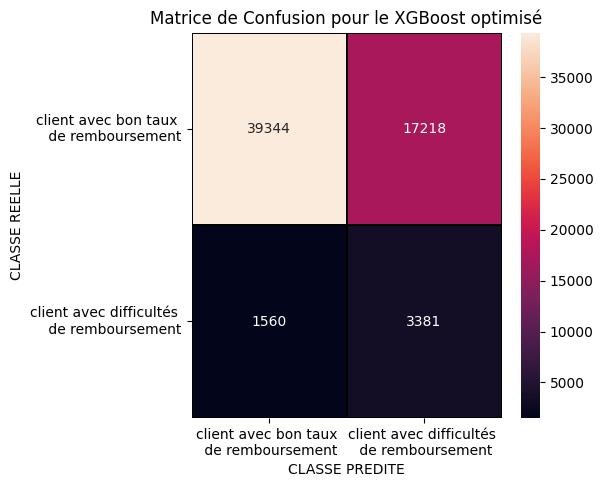

In [ ]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_pred_bst_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XGBoost optimisé')
plt.show()

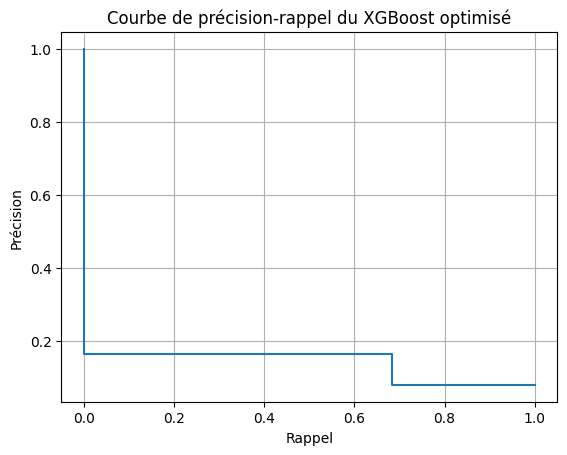

In [ ]:
# Graphique précision-rappel
precision_bst, recall_bst, _ = precision_recall_curve(y_test, y_pred_bst_gd)
disp_bst = PrecisionRecallDisplay(precision=precision_bst, recall=recall_bst)
disp_bst.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du XGBoost optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du XGBoost optimisé')

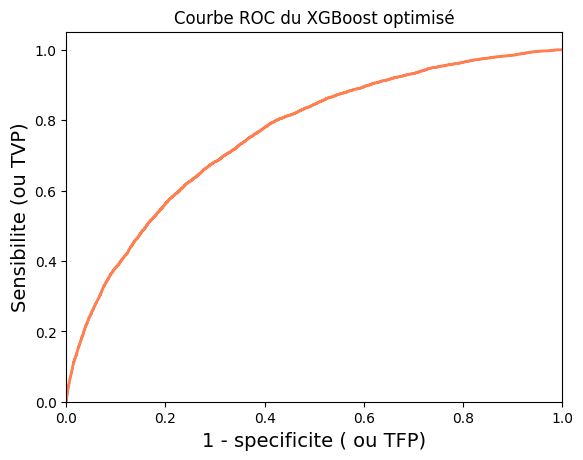

In [ ]:
# Graphique courbe ROC
[fpr_bst, tpr_bst, thr_bst] = metrics.roc_curve(y_test, y_prob_bst_gd)
plt.plot(fpr_bst, tpr_bst, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du XGBoost optimisé')

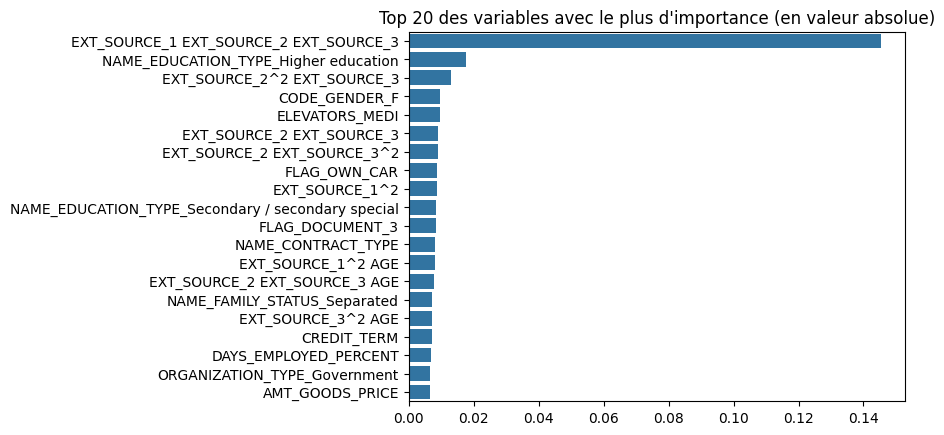

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_bst = (pd.Series(best_model_bst_gs.feature_importances_,X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_bst, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que la combinaisons créée avec les 3 données EXT_SOURCE a une importance beaucoup plus élevée que toutes les autres dans ce modèle optimisé de XGBoost.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [ ]:
# F3 score selon les différents seuils de décision
f3_score_bst=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_bst_gd > i, 1, 0))
  f3_score_bst.append(str(fbeta_score(y_test,preds, beta=3)))


In [ ]:
y_prob_bst_gd.shape

(61503,)

In [ ]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_bst})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


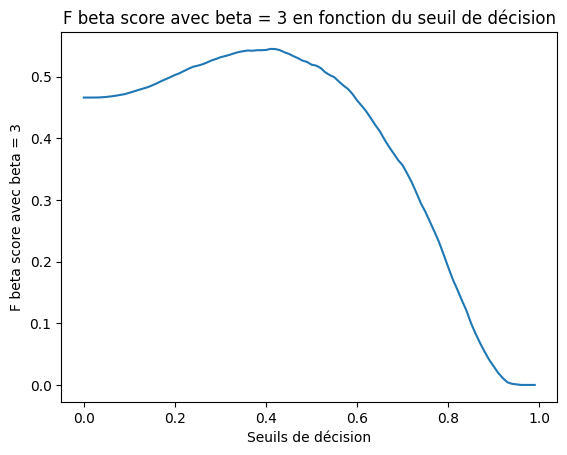

In [ ]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

In [ ]:
# Cherchons la valeur maximale du F3 score
f3_score_bst_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_bst=df.loc[df['f3_score']==f3_score_bst_max,['abs']]
seuil_opt_bst=seuil_opt_bst.values[0,0]
seuil_opt_bst

0.41

In [ ]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_bst_opt=(y_prob_bst_gd> seuil_opt_bst).astype(int)

In [ ]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_test,y_bst_opt)))
print('Precision Score : ' + str(precision_score(y_test,y_bst_opt)))
print('Recall Score : ' + str(recall_score(y_test,y_bst_opt)))
print('F1 Score : ' + str(f1_score(y_test,y_bst_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_bst_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_bst_opt)))

Accuracy Score : 0.5853535599889437
Precision Score : 0.13952102107367018
Recall Score : 0.8053025703298927
F1 Score : 0.2378362223550508
F beta Score (avec beta=3) : 0.5451581081821669
Aire sous la courbe ROC : 0.685721190755272


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,41.

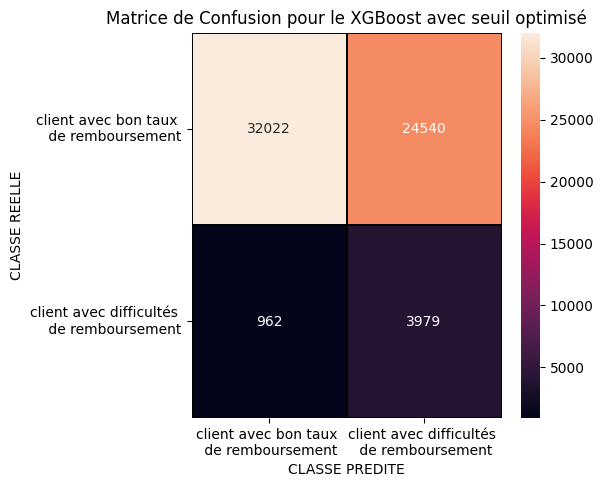

In [ ]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_bst_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XGBoost avec seuil optimisé')
plt.show()

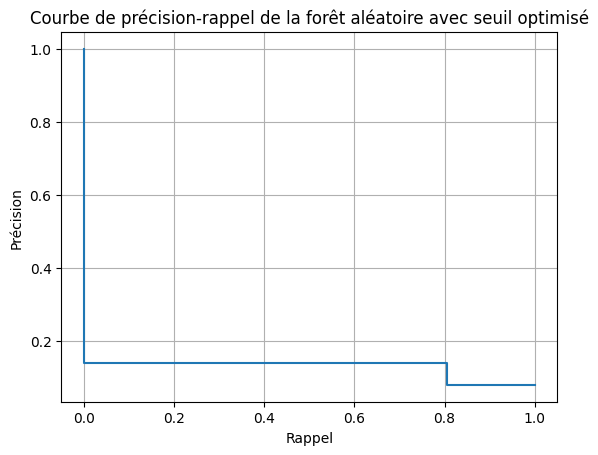

In [ ]:
# Graphique précision-rappel
precision_bst, recall_bst, _ = precision_recall_curve(y_test, y_bst_opt)
disp_bst = PrecisionRecallDisplay(precision=precision_bst, recall=recall_bst)
disp_bst.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du XGBoost avec seuil optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du XGBoost avec seuil optimisé')

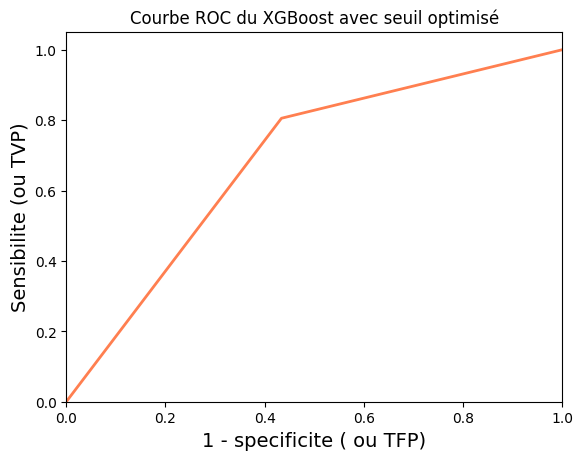

In [ ]:
# Graphique courbe ROC
[fpr_bst, tpr_bst, thr_bst] = metrics.roc_curve(y_test, y_bst_opt)
plt.plot(fpr_bst, tpr_bst, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du XGBoost avec seuil optimisé')

Puisque notre but est de maximiser le F3 score, l'algorithme XGBoost après optimisation du seuil est le meilleur avec un F3 score de 0.5451581081821669 et une bonne rapidité.

## Explication du modèle :

Observons maintenant comment les variables les plus importantes influencent les prédictions avec la fonction SHAP.

In [ ]:
explainer = shap.TreeExplainer(best_model_bst_gs)
shap_values = explainer.shap_values(X_test_norm)

### Global :

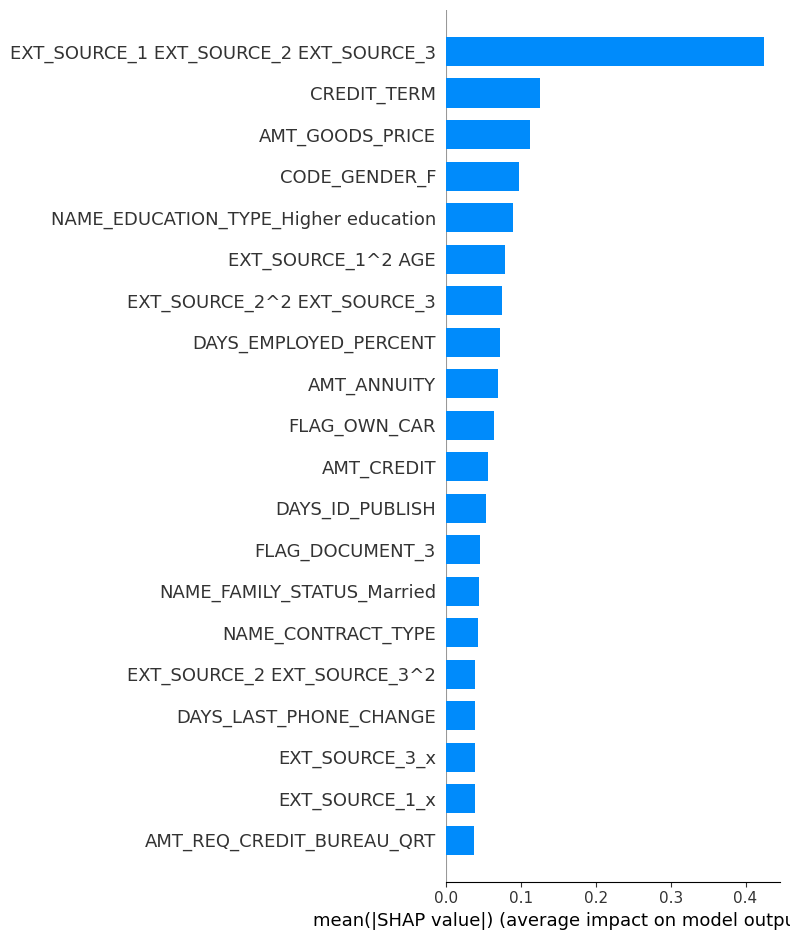

In [ ]:
shap.summary_plot(
    shap_values, X_test_norm, feature_names=X_test_norm.columns, plot_type="bar"
)

On trouve quelques différences avec la fonction feature_importance mais on retrouve la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" qui prédomine.

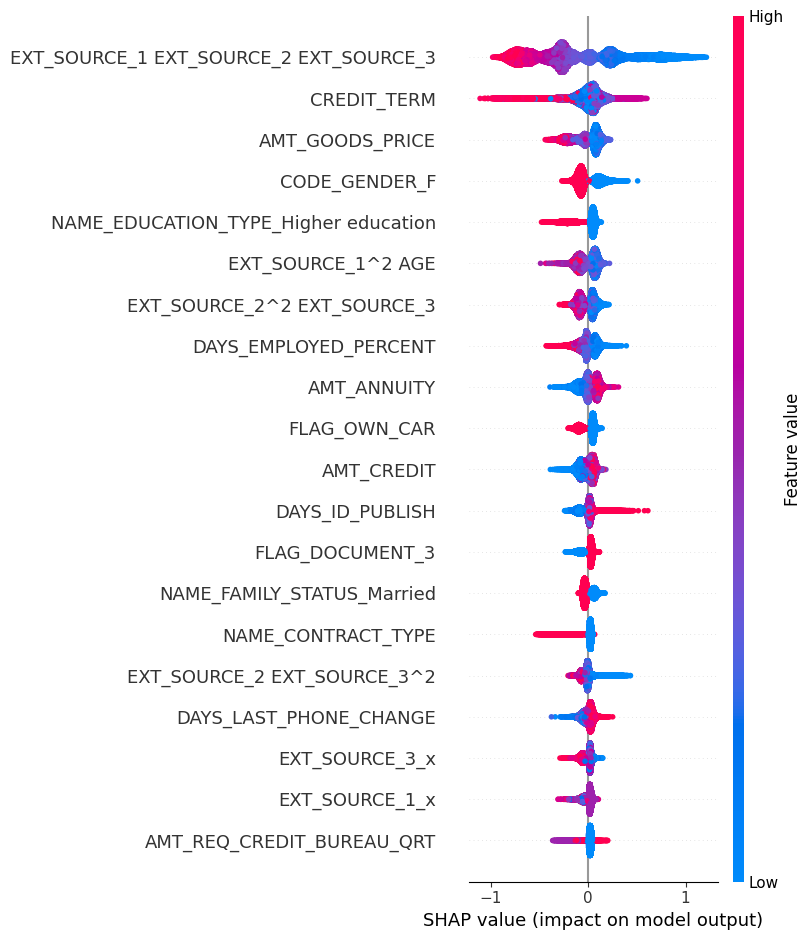

In [ ]:
shap.summary_plot(shap_values, X_test_norm)

Avec ce nouveau graphique, on peut voir que la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" a essentiellement une influence négative sur le modèle quand ces valeurs sont hautes, de même pour CREDIT_TERM. Cela signifie que, lorsque ces variables prennent des valeurs élevées dans une prédiction, il y a de fortes chances que le résultat de la classification soit 0 (classe avec bon taux de remboursement).

Nous pouvons également remarque que le genre féminin a une influence négative sur le modèle.

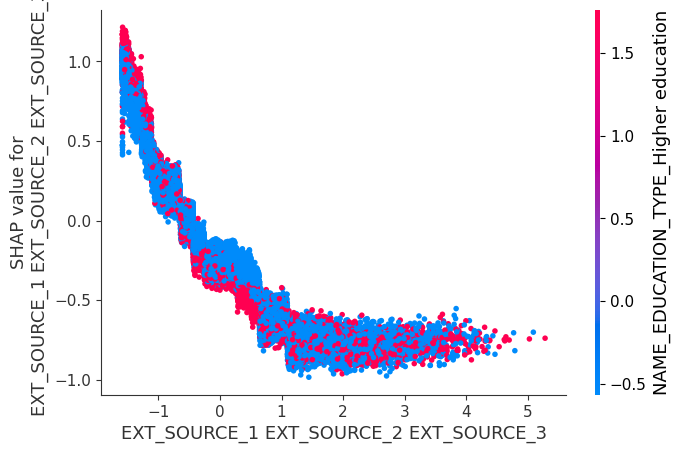

In [ ]:
shap.dependence_plot("EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3", shap_values, X_test_norm, interaction_index="auto")

On retrouve le fait que lorsque la valeur de la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" augmente, la valeur de SHAP de cette combinaison diminue.

Apparemment, la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" interagit plus avec la variable "NAME_EDUCATION_TYPE_Higher education" qu'avec les autres variables. Cependant, aucune corrélation ne semble pouvoir être déterminée visuellement entre ces deux variables.

### Local :

In [ ]:
shap_explainer_values = explainer(X_test_norm, y_test)


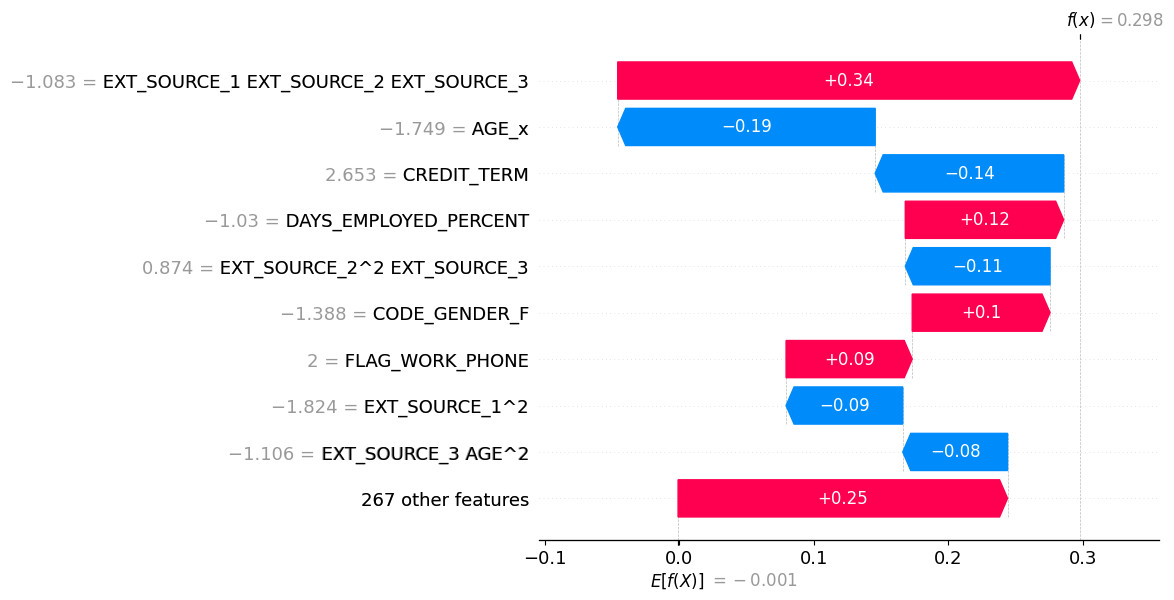

In [ ]:
#  Choix d'un individu aléatoire pour l'explication locale
random_idx = np.random.randint(len(X_test_norm))
shap.waterfall_plot(shap_explainer_values[random_idx])

Pour ce premier individu, on peut voir que la prédiction finale est plus fortement influencée positivement par les "autres variables" (+0.25) ainsi que par la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" (+0.34) qui a une valeur négative de -1.083 (donc une influence positive comme montrée dans l'explication globale au dessus).
L'influence négative la plus importante vient de la variable "AGE" (-0.19).

La prédiction finale est positive (0.298) et tend à classifier cet individu dans la classe 1 des individus avec des difficultés de remboursement.

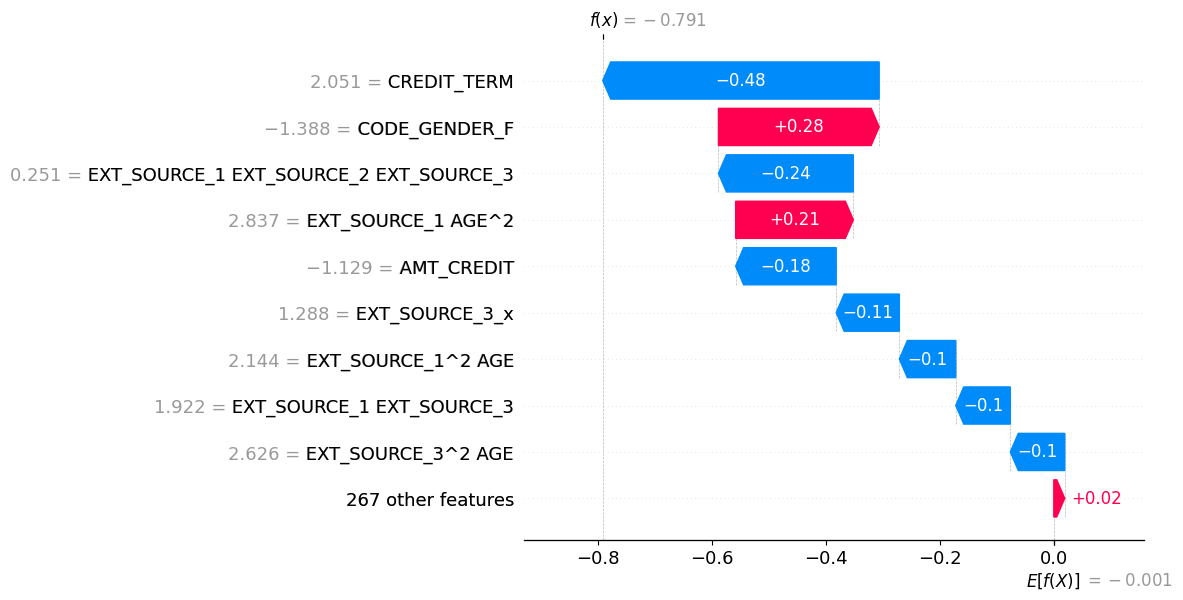

In [ ]:
#  Choix d'un individu aléatoire pour l'explication locale
random_idx = np.random.randint(len(X_test_norm))
shap.waterfall_plot(shap_explainer_values[random_idx])

Pour ce deuxième individu, on peut voir que la prédiction finale est plus fortement influencée négativement par la variable "CREDIT_TERM" (-0.48) ainsi que par la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" (-0.24). Ces deux variables ont des valeurs positives, respectivement de 2.051 et 0.251, et ont donc une influence négative comme montrée dans l'explication globale au dessus.

Les influences négatives les plus importantes viennent de la variable "CODE_GENDER_F" (+0.28) ainsi que par la combinaison "EXT_SOURCE_1 AGE^2" (+0.21). La variable "CODE_GENDER_F" a une valeur négative, l'individu est donc un homme, ce qui explique l'influence positive de la variable comme montrée dans l'explication globale au dessus.

La prédiction finale est négative (-0.791) et tend à classifier cet individu dans la classe 0 des individus avec un bon taux de remboursement.

#### Limitations

Le fait que les variables "EXT_SOURCE" soient des scores normalisés dont on ne connait pas vraiment ni la source ni le contenu, ne permet pas d'aller plus loin en terme d'explicabilité "métier" du modèle.

**Ressources :**


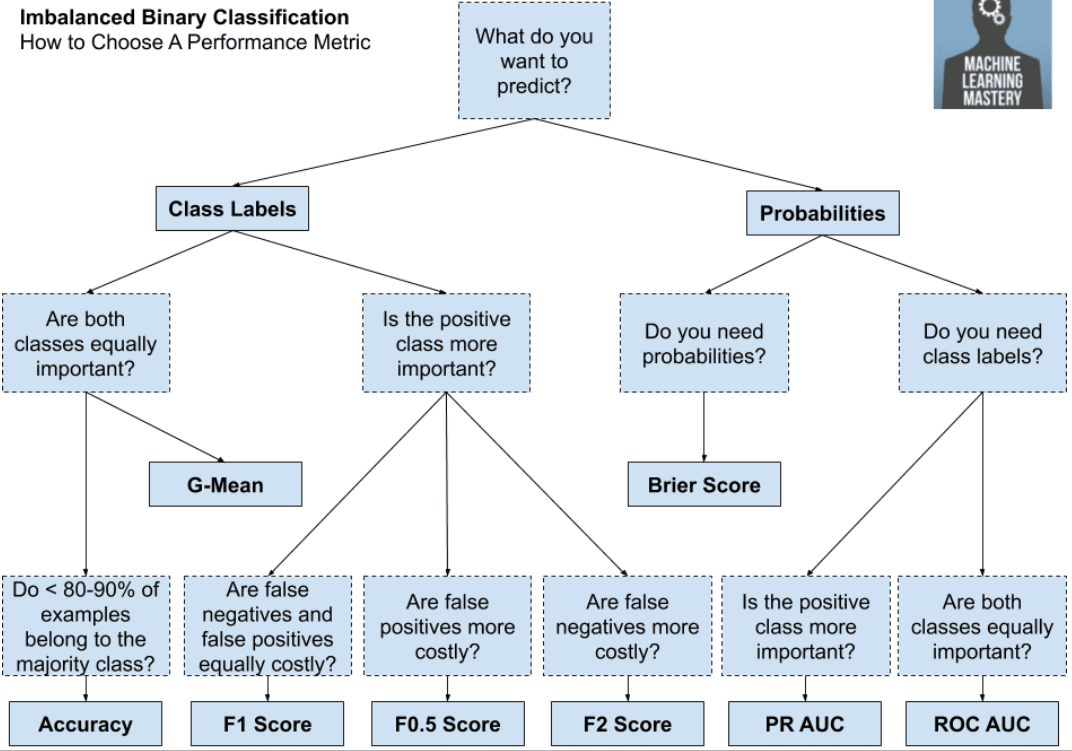

In [ ]:
#  FONCTION PIPELINE

# EXEMPLE 1 :
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),        #On normalise les données
#     ('pca', PCA(n_components=3)),        #On réduit la dimension
#     ('regressor', GradientBoostingRegressor(n_estimators=100,     learning_rate=0.1, max_depth=3, random_state=42))
# #On entraîne le modèle
# ])

# #On entraîne le modèle en utilisant le pipeline

# pipeline.fit(X_train, y_train)

# #Finalement, on évalue le modèle

# predictions = pipeline.predict(X_test)
# mse = mean_squared_error(y_test, predictions)
# print("Erreur quadratique moyenne :", mse)



# EXEMPLE 2 :
# pipe = Pipeline([
#     ('model', StandardScaler()),
#     ('model', DummyClassifier())
# ])

# grid = GridSearchCV(estimator=pipe,
#                     param_grid={'model__strategy': ['stratified', 'most_frequent', 'uniform']},
#                     cv=5,
#                     scoring={'acc': make_scorer(accuracy_score)},
#                     refit='acc',
#                     return_train_score=True)

# grid.fit(X, y)
# pd.DataFrame(grid.cv_results_)[['param_model__strategy', 'mean_test_acc']]